The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



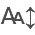

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from venn import venn
from collections import OrderedDict
import pkg_resources
%load_ext rpy2.ipython 
from itables import init_notebook_mode, show
init_notebook_mode()
from adjustText import adjust_text
from IPython.display import display, Markdown

## Scientific questions

The goal of this notebook is to answer the research questions listed below. 

1. Compare Strains to Each Other

How does the transcriptome change if `dinB` or `katE` are knocked out? How does the response to antibiotic exposure change? (Specifically looking at stress responses)
- MG1655 (S-NT) vs. dinB (S-NT)
- MG1655 (S-T) vs. dinB (S-T)
- MG1655 (S-NT) vs. katE (S-NT)
- MG1655 (S-T) vs. katE (S-T)

2. Compare Susceptible to Evolved Strains

How does the adaptation/evolution/mutations influence the transcriptome?
- MG1655 (S-NT) vs. MG1655 (E-NT)
- dinB (S-NT) vs. dinB (E-NT)
- katE (S-NT) vs. katE (E-NT)

3. Compare Evolved Trajectories

Check for commonalities and differences (Venn diagram)
- MG1655 (E-NT) vs. katE (E-NT)
- MG1655 (E-T) vs. katE (E-T)
- MG1655 (E-NT) vs. dinB (E-NT)
- MG1655 (E-T) vs. dinB (E-T)

4. Compare Transcriptome Under Treatment

- MG1655 NT vs. T (E-NT vs. E-T)
- dinB NT vs. T
- katE NT vs. T

5. Compare DNA Results to RNA Data

 Mutation Impact on RNA Expression
- Do mutations cause a change in RNA expression levels?
- frdD
- prlF/yhaV -> ompF downregulation?
- rpoD Sigma70 (and related pathways) -> rpoS Sigma30 influenced?
- rpoA (in dinB, related pathways)
- ampC
- waas
- ybgD/gltA

6. Is the pre-plasmid region upregulated?

- See gene copy number analysis and relate to RNA expression
- Genes of interest: yjeJ, epmB, epmA, efp, ecnA, ecnB, sugE/gdx, blc, ampc, frdD, frdC, frdB, frdA, yjeM
- Probably also interesting to check insA and insB

7. Do we see common mechanism of resistance?

- Check Lisa’s list with gene targets (porins, efflux pumps)

8. Knockout Mutant Pathways

Are `dinB` or `katE` upregulated in MG1655 (S-T) vs. MG1655 (S-NT)?
Is the SOS response (recA as indicator)/oxidative stress response upregulated?
- Check MG1655, dinB, and katE for changes.
- Do other error-prone DNA POL take over if `dinB` is knocked out?
- Do other catalases take over if `katE` is knocked out?

First I will do the edgeR analysis in R, and then do the rest of the analysis in Python or R.


## Assumptions

1. For the GO analysis I will only include hits from Biological Process. 
2. The KEGG/GO analyses are not FDR corrected. Here are the authors rationale for this:

>The p-values returned by goana and kegga are unadjusted for multiple testing. The authors have chosen not to correct automatically for multiple testing because GO terms and KEGG pathways are often overlapping, so standard methods of p-value adjustment may be very conservative. Users should be aware though that p-values are unadjusted, meaning that only very small p-values should be used for published results. 

A GO or KEGG can be considered significant in this analysis if p is equal or smaller than 0.001.

3. If a comparison is define like this `MG1655 (S-NT) vs. dinB (S-NT)`, it will be labeled like this in the plots `dinb_POS_NT`. If a gene is differentially expressed and has a positive logFC, it means that it is over expressed in  `dinb_POS_NT` in relation to `MG1655_POS_NT`.  In this case `dinb_POS_NT` will be in the `First`column and `MG1655_POS_NT` in the `Second`columnm. 

4. E = AMO \
   S = POS \
   ei. MG1655 (S-NT) = MG1655_POS_NT and MG1655 (E-NT) = MG1655_AMO_NT

Loading R libraries. 

In [3]:
%%R

# Load R packages
suppressPackageStartupMessages({
library(edgeR)
library(tidyverse)
library(dplyr)
library(org.EcK12.eg.db)
library(GO.db)
library(viridis)
library(DT)
library(glue)
library(ggtext)
library(ggrepel)
library(ggpubr)
library()
})

File: /tmp/RtmptDZ1Op/RlibraryIQR3d56334bb3bc0
Packages in library '/opt/conda/lib/R/library':



AnnotationDbi           Manipulation of SQLite-based annotations in

                        Bioconductor

Biobase                 Biobase: Base functions for Bioconductor

BiocGenerics            S4 generic functions used in Bioconductor

BiocManager             Access the Bioconductor Project Package

                        Repository

BiocVersion             Set the appropriate version of Bioconductor

                        packages

Biostrings              Efficient manipulation of biological strings

CNOGpro                 Copy Numbers of Genes in prokaryotes

DBI                     R Database Interface

DT                      A Wrapper of the JavaScript Library

                        'DataTables'

Deriv                   Symbolic Differentiation

GO.db                   A set of annotation maps describing the entire

                        Gene Ontology

GenomeInfoDb        

Load data and clean it.

In [4]:
%%R -o df_key
#"""
#Post processing of input file to create groups etc.
#"""

df_key <- read_delim('documentation/RNA/egdeR_analysis/RNA_seq_metadata.txt',show_col_types = FALSE)

df <- read_table('scripts/nextflow_RNA/work/04/f4f9613c3a6ce172fe37f6119b3770/featurecounts_comb.txt',
show_col_types = FALSE)

# load KEGG translation data
df_conv <- read_table('documentation/RNA/egdeR_analysis/ncbi-geneid.tsv', col_names = FALSE, show_col_types = FALSE)

# Remove junk strings
df_conv$X1 <- str_replace_all(df_conv$X1, "ncbi-geneid:", "")
df_conv$X2 <- str_replace_all(df_conv$X2, "eco:", "")

# Replace column names
colnames(df_conv) <- c('gene_id_kegg', 'Geneid')
df_conv$gene_id_kegg <- as.integer(df_conv$gene_id_kegg)

# combine data frames
df <- merge(df, df_conv, by = 'Geneid')

# create a named vector mapping library name to final_names
name_mapping <- setNames(df_key$final_names, df_key$Sample_code)

# rename the columns of df2. Replacing fasta file name with sample name
df <- rename_with(df, ~ ifelse(. %in% names(name_mapping), name_mapping[.], .))

# Remove the digit at the end of each sample name in columns 7 to 43
grp <- sub("_\\d$", "", colnames(df)[7:43])

# Only the samples that were extracted the first time have NA values in the df_key
# This code identifies those rows
first_sampling <- df_key[!complete.cases(df_key), ]$final_names

# Divide the samples in when they were sampled
sampling_groups <- ifelse(colnames(df)[7:43] %in% first_sampling, "first", "second")

# Extract 
split_list <- str_split(colnames(df)[7:43], "_", n = 4)
replicate <- sapply(split_list, "[", 4)

Initial egeR data preparation. 

In [5]:
%%R

#"""
#Create edgeR file format, calculate dispersion and fit model. 
#"""

# Create DGElist
y <- DGEList(counts=df[7:43], group = grp, genes = df[,44:45])

# Remove low expression genes 
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]

# Calculate normalization factor
y <- calcNormFactors(y)

# create model matrix
design <- model.matrix(~  0 +  grp + sampling_groups  , data=y$samples)

y <- estimateDisp(y, design, robust=TRUE)
fit <- glmQLFit(y, design, robust=TRUE)

## Sample overview

This MDS plot shows which samples are similar or distant to each other.

From docs: 

>Plot samples on a two-dimensional scatterplot so that distances on the plot approximate the expression differences between the samples. 

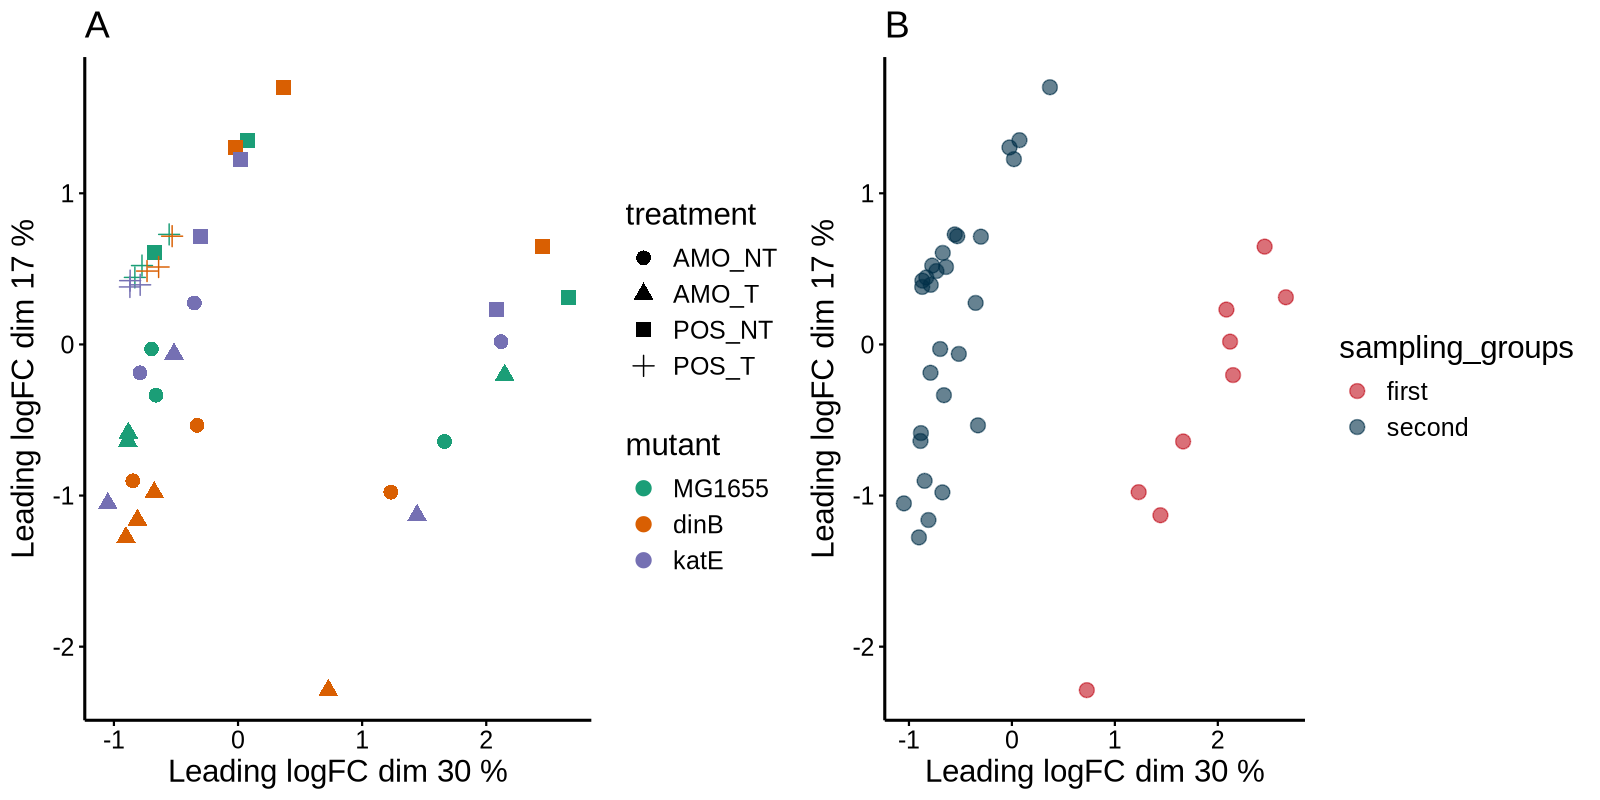

In [6]:
%%R -w 1600 -h 800 -r 150 

x_axis <- plotMDS(y, plot = FALSE)$x   
y_axis <- plotMDS(y, plot = FALSE)$y  

# extract % contribution of dimentions
x_axis_var_explained <- round(plotMDS(y, plot = FALSE)$var.explained[1] * 100)
y_axis_var_explained <- round(plotMDS(y, plot = FALSE)$var.explained[2] * 100)

# Convert to readeble axis lables
x_axis_var_explained <- paste('Leading logFC dim', as.character(x_axis_var_explained), '%')
y_axis_var_explained <- paste('Leading logFC dim', as.character(y_axis_var_explained), '%')

# Combine to one df
plot_df <- cbind(y$sample$group, x_axis, y_axis)
# Make number integers isted of characters
plot_df <- transform(plot_df, x_axis = as.numeric(x_axis), 
                     y_axis = as.numeric(y_axis))

split_list <- str_split(grp, "_", n = 2)
# Extract the first and second parts
mutant <- sapply(split_list, "[", 1)  # This will contain 'katE', 'dinB', 'MG1655', etc.
treatment <- sapply(split_list, "[", 2)  # This will contain 'POS_NT', 'AMO_NT', 'POS_T', etc.

p1 <- plot_df %>%
ggplot(aes(x = x_axis, y = y_axis, color = mutant, shape = treatment)) +
  geom_point(alpha = 1, size = 3) +
  xlab(x_axis_var_explained) +
  ylab(y_axis_var_explained) +
  ggtitle('A') +
  scale_color_manual(values = c('#1b9e77','#d95f02','#7570b3')) +
  theme(
    text=element_text(size = 15),
    legend.key=element_blank(),
    strip.text.x = element_text(colour = "black"),
    panel.spacing = unit(1, "lines"),
    strip.background = element_rect(colour = NA, fill = NA),
    axis.line = element_line(linewidth = 0.7, colour = "black"),
    panel.background = element_rect(fill = 'white'),
    axis.text.y = element_text(color="black"),
    axis.text.x = element_text(color="black"),
    axis.ticks = element_line(color = 'black'),
    axis.title = element_text(),
    legend.text = element_text(),
    legend.title  = element_text(),
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_blank(),
    legend.position = "right") 


p2 <- plot_df %>%
ggplot(aes(x = x_axis, y = y_axis, color = sampling_groups)) +
  geom_point(alpha = 0.6, size = 3) +
  #geom_text() +
  xlab(x_axis_var_explained) +
  ylab(y_axis_var_explained) +
  ggtitle('B') +
  scale_color_manual(values = c('#c1121f','#003049')) +
  theme(
    text=element_text(size = 15),
    legend.key=element_blank(),
    strip.text.x = element_text(colour = "black"),
    panel.spacing = unit(1, "lines"),
    strip.background = element_rect(colour = NA, fill = NA),
    axis.line = element_line(linewidth = 0.7, colour = "black"),
    panel.background = element_rect(fill = 'white'),
    axis.text.y = element_text(color="black"),
    axis.text.x = element_text(color="black"),
    axis.ticks = element_line(color = 'black'),
    axis.title = element_text(),
    legend.text = element_text(),
    legend.title  = element_text(),
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_blank(),
    legend.position = "right")    

ggarrange(p1, p2, nrow = 1)

**A:** Samples labeled according to mutation and treatment. **B:** Samples labeled according to sampling round. 

### Sample table

This is a table of what sample id is linked to what treatment. 

In [7]:
df_key

Sample_code library_name  stock_conc_(nM) Library_Index  Strain  \
1          S01          S01           5584.0        ATCACG  MG1655   
2          S02          S02           9437.0        CGATGT  MG1655   
3          S03          S03           1316.0        TTAGGC  MG1655   
4          S04          S04          10303.0        TGACCA  MG1655   
5          S05          S05           9957.0        CAGATC  MG1655   
6          S06          S06          14719.0        ACTTGA  MG1655   
7          S07          S07          15498.0        GATCAG  MG1655   
8          S08          S08          15325.0        TAGCTT  MG1655   
9          S09          S09          14113.0        GGCTAC  MG1655   
10         S10          S10           9784.0        CTTGTA    dinB   
11         S11          S11           6753.0        AGTCAA    dinB   
12         S12          S12          15411.0        AGTTCC    dinB   
13         S13          S13          14632.0        ATGTCA    dinB   
14         S14          S14           7359.0        GTCCGC    dinB   
15         S15          S15          10909.0        GTGAAA    dinB   
16         S16          S16          12468.0        GTGGCC    dinB   
17         S17          S19           5281.0        GTTTCG    katE   
18         S18          S20           1013.0        CGTACG    katE   
19         S19          S21          11342.0        ACTGAT    katE   
20         S20          S22           1316.0        GTAGAG    katE   
21         S21          S23           8528.0        GGTAGC    katE   
22         S22          S24          14113.0        ATGAGC    katE   
23         S23          S25          11861.0        ATTCCT    katE   
24         S24          S26          29264.0        CAAAAG    katE   
25         S25          S27          17662.0        CAACTA    katE   
26         S26          S30          15411.0        CACGAT    dinB   
27         S27          S31          15584.0        CACTCA    dinB   
28         S28          S32          14545.0        CAGGCG    dinB   
29     S17_S17         None              NaN          None  MG1655   
30     S24_S24         None              NaN          None  MG1655   
31     S25_S25         None              NaN          None  MG1655   
32     S26_S26         None              NaN          None    dinB   
33     S28_S28         None              NaN          None    dinB   
34     S29_S29         None              NaN          None    dinB   
35     S31_S31         None              NaN          None    katE   
36     S32_S32         None              NaN          None    katE   
37     S33_S33         None              NaN          None    katE   

   Resistant_or_Suspectible_strain  \
1                                S   
2                                S   
3                                S   
4                                S   
5                                S   
6                                R   
7                                R   
8                                R   
9                                R   
10                               S   
11                               S   
12                               S   
13                               S   
14                               S   
15                               R   
16                               R   
17                               S   
18                               S   
19                               S   
20                               S   
21                               S   
22                               R   
23                               R   
24                               R   
25                               R   
26                               R   
27                               R   
28                               R   
29                            None   
30                            None   
31                            None   
32                            None   
33                            None   
34                            None   
35          

## Defining functions for data analysis
Function for performing transcriptome analysis as well as GO an KEGG analysis


In [8]:
%%R

  #"""
  # This function takes the DEGElist object, defined contrasts and the model design and performs a differential expression analysis of genes, Go and KEGG pathways.
  # Afterwards it cleaned the data and outputs one df per test. 
  #"""
  
perform_analysis <- function(fit, design, my_contrasts, question) {
  # Initialize empty data frames for storing KEGG and GO results
  df_kegg = data.frame()
  df_go = data.frame()
  df_tr = data.frame()

  # Loop through the contrasts
  for (contrast_name in colnames(my_contrasts)) {
    # Run the glmQLFTest for the current contrast
    test_results <- glmQLFTest(fit, contrast=my_contrasts[, contrast_name])
    contrast_name <- test_results$comparison

    # Convert the result to a data frame
    result_df <- as.data.frame(test_results$table)
    result_df <- cbind(result_df, test_results$genes)

    # Add a column with the contrast name
    result_df$contrast <- contrast_name

    # Append the transcriptome result to the df_tr data frame
    df_tr <- rbind(df_tr, result_df) 
    
    # Go test
    go_test <- goana(test_results, species = 'EcK12', geneid = test_results$genes$gene_id_kegg)
    
    # If significant Go's were found 
    if (!is.null(go_test) && nrow(go_test) > 0) {
      
      # select down regulated GO
      go_down <-dplyr::select(go_test, Term, Ont, N, Down, P.Down)
      go_down <- dplyr::rename(go_down, Significant = Down , P = P.Down)
      go_down$Direction <- "Down"
  
      # select up regulated GO
      go_up <-dplyr::select(go_test, Term, Ont, N, Up, P.Up)
      go_up <- dplyr::rename(go_up, Significant = Up , P = P.Up)
      go_up$Direction <- "Up"
  
      # Combine and append to final df
      go_df_partial<- rbind(go_down, go_up)
      
      # Only keep biological process
     # go_df_partial <- filter(go_df_partial, Ont == 'BP')
      go_df_partial$contrast <- contrast_name
      df_go <- rbind(df_go, go_df_partial)
    
    } else {
      message("No significant GO results for contrast: ", contrast_name)
    }

   # KEGG pathway analysis
    kegg_df <- kegga(test_results, species.KEGG = 'eco', geneid = test_results$genes$gene_id_kegg, convert=TRUE)

    # If significant pathways were found
    if (!is.null(kegg_df) && nrow(kegg_df) > 0) {

      # select down regulated KEGGs
      kegg_down <-dplyr::select(kegg_df, Pathway, N, Down, P.Down)
      kegg_down <- dplyr::rename(kegg_down, Significant = Down , P = P.Down)
      kegg_down$Direction <- "Down"

      # select up regulated KEGGs
      kegg_up <-dplyr::select(kegg_df, Pathway, N, Up, P.Up)
      kegg_up <- dplyr::rename(kegg_up, Significant = Up , P = P.Up)
      kegg_up$Direction <- "Up"

      # Combine to single df
      kegg_df_partial <- rbind(kegg_up, kegg_down)
      kegg_df_partial$contrast <- contrast_name

      df_kegg<- rbind(df_kegg, kegg_df_partial)
    } else {
      message("No significant KEGG results for contrast: ", contrast_name)
    }
  }

   # Define a function to clean and reorder contrast names
    clean_and_reorder_contrast <- function(contrast_name) {
      # Remove numerical coefficients and asterisks
      cleaned_name <- gsub(pattern = "-?\\d*\\*", replacement = "", contrast_name)
      cleaned_name <- gsub("grp", "", cleaned_name)
  
      # Split the string into parts based on spaces
      parts <- unlist(strsplit(cleaned_name, " "))
  
      # Remove empty elements caused by extra spaces
      parts <- parts[nzchar(parts)]
  
      # Reorder parts to move the second term to the front and connect with '_'
      # This will put the control first in the name making it more intuitive.
      reordered_name <- paste(parts[1], parts[2], sep = "_")
  
      return(reordered_name)
  }
  
  # Apply the function to the 'contrast' column of your results data frame
  df_tr$cleaned_contrast <- sapply(df_tr$contrast, clean_and_reorder_contrast)
  df_go$cleaned_contrast <- sapply(df_go$contrast, clean_and_reorder_contrast)
  df_kegg$cleaned_contrast <- sapply(df_kegg$contrast, clean_and_reorder_contrast)
  
  # label question
  df_tr$Question <- question
  df_go$Question <- question
  df_kegg$Question <- question
  
  list(df_tr = df_tr, df_kegg = df_kegg, df_go = df_go) 
}

Here I define contrasts and call the analysis function. 

Text below are samples where there were no significant groups (KEGG, go or genes). 

In [9]:
%%R -o df_all_tr -o df_all_kegg -o df_all_go  

# Here I define the contrasts for this question and call the perform_analysis function

my_contrasts_1 <- makeContrasts(
  katE_POS_NT_MG_POS_NT = grpkatE_POS_NT - grpMG1655_POS_NT,
  dinB_POS_NT_MG_POS_NT = grpdinB_POS_NT - grpMG1655_POS_NT,
  
  katE_POS_T_MG_POS_T = grpkatE_POS_T - grpMG1655_POS_T,
  dinB_POS_T_MG_POS_T = grpdinB_POS_T - grpMG1655_POS_T,
  levels = design
)

my_contrasts_2 <- makeContrasts(
  MG1655_AMO_NT_MG1655_POS_NT = grpMG1655_AMO_NT - grpMG1655_POS_NT,
  katE_AMO_NT_katE_POS_NT = grpkatE_AMO_NT - grpkatE_POS_NT,
  dinB_AMO_NT_dinB_POS_NT = grpdinB_AMO_NT - grpdinB_POS_NT,

  levels = design
)

my_contrasts_3 <- makeContrasts(
    
  katE_AMO_NT_MG1655_AMO_NT = grpkatE_AMO_NT - grpMG1655_AMO_NT,
  katE_AMO_T_MG1655_AMO_T = grpkatE_AMO_T - grpMG1655_AMO_T,
  dinB_AMO_NT_MG1655_AMO_NT = grpdinB_AMO_NT - grpMG1655_AMO_NT,
  dinB_AMO_T_MG1655_AMO_T = grpdinB_AMO_T - grpMG1655_AMO_T,
  
  levels = design
)

my_contrasts_4 <- makeContrasts(
  MG1655_AMO_T_MG1655_AMO_NT = grpMG1655_AMO_T - grpMG1655_AMO_NT,
  dinB_AMO_T_dinB_AMO_NT = grpdinB_AMO_T - grpdinB_AMO_NT,
  katE_AMO_T_katE_AMO_NT = grpkatE_AMO_T - grpkatE_AMO_NT,
  
  levels = design
)

# Perform differential expression analysis/KEGG/GO
df_all_q1  <- perform_analysis(fit, design, my_contrasts_1, "1")
df_all_q2  <- perform_analysis(fit, design, my_contrasts_2, "2")
df_all_q3  <- perform_analysis(fit, design, my_contrasts_3, "3")
df_all_q4  <- perform_analysis(fit, design, my_contrasts_4, "4")

# combine to a singe df
df_all_tr <- rbind(df_all_q1$df_tr, df_all_q2$df_tr, df_all_q3$df_tr, df_all_q4$df_tr)
df_all_kegg <- rbind(df_all_q1$df_kegg, df_all_q2$df_kegg, df_all_q3$df_kegg, df_all_q4$df_kegg)
df_all_go <- rbind(df_all_q1$df_go, df_all_q2$df_go, df_all_q3$df_go, df_all_q4$df_go)

# Perform FDR correction
df_all_tr$FDR <- p.adjust(df_all_tr$PValue, method = "fdr")

R[write to console]: No DE genes

R[write to console]: No significant GO results for contrast: -1*grpMG1655_AMO_NT 1*grpMG1655_AMO_T

R[write to console]: No DE genes

R[write to console]: No significant KEGG results for contrast: -1*grpMG1655_AMO_NT 1*grpMG1655_AMO_T



This is a data cleaning function which make the data easier to work with. IT als outputs a table with the number of significant genes, Go or KEGG pathways.  

In [10]:
"""
1. This function labels if a gene was up, down or not significantly different in expression. 

2. Here I extract the samples relevant for question and print the number of significant up or down regulated Go terms (biological process), KEGG pathways and genes. 
"""
def python_parse(df_tr, df_go, df_kegg):
    # Function to determine label
    def determine_label(row, p_value_threshold=0.05, fold_change_up_threshold=0, fold_change_down_threshold=0):
        if row['FDR'] <= p_value_threshold:
            if row['logFC'] > fold_change_up_threshold:
                return 'Up'
            elif row['logFC'] < fold_change_down_threshold:
                return 'Down'
        else:
            return 'Non-significant'

    # Function to split cleaned_contrast at the third underscore and return parts
    def split_contrast(contrast):
        parts = contrast.split(' ')

        # Check each part for the presence of "-1" and "1"
        for part in parts:
            if "-1" in part:
                has_minus_one = part.split('grp')[1]
            elif "1" in part:
                has_one_only = part.split('grp')[1]
                     
        return  has_one_only, has_minus_one

    # Apply determine_label to each row
    df_tr['label'] = df_tr.apply(determine_label, axis=1)

    # Apply split_contrast to each row for 'cleaned_contrast' and create new columns
    df_tr[['First', 'Second']] = df_tr['contrast'].apply(lambda x: split_contrast(x)).apply(pd.Series)
    df_go[['First', 'Second']] = df_go['contrast'].apply(lambda x: split_contrast(x)).apply(pd.Series)
    df_kegg[['First', 'Second']] = df_kegg['contrast'].apply(lambda x: split_contrast(x)).apply(pd.Series)

    # Calculate log10 on p-value
    df_tr['log10FDR'] = round(-np.log10(df_tr['FDR']), 4)
    df_go['log10P'] = round(-np.log10(df_go['P']), 4)
    df_kegg['log10FDR'] = round(-np.log10(df_kegg['P']), 4)

    # Calculate proportion of significant genes within category
    df_go['Proportion_significant'] = df_go.Significant / df_go.N
    df_kegg['Proportion_significant'] = df_kegg.Significant / df_kegg.N

    # Filter significant entities per group
    len_kegg_up = len(df_kegg[(df_kegg['P'] < 0.001) & (df_kegg.Direction == 'Up')])
    len_kegg_down = len(df_kegg[(df_kegg['P'] < 0.001) & (df_kegg.Direction == 'Down')])

    #len_go_up = len(df_go[(df_go['P'] < 0.001) & (df_go.Direction == 'Up') & (df_go.Ont == 'BP')])
    #len_go_down = len(df_go[(df_go['P'] < 0.001) & (df_go.Direction == 'Down')& (df_go.Ont == 'BP')])
    
    len_go_up = len(df_go[(df_go['P'] < 0.001) & (df_go.Direction == 'Up') ])
    len_go_down = len(df_go[(df_go['P'] < 0.001) & (df_go.Direction == 'Down')])

    len_tr_up = len(df_tr[(df_tr.FDR < 0.05) & (df_tr.label == 'Up')])
    len_tr_down = len(df_tr[(df_tr.FDR < 0.05) & (df_tr.label == 'Down')])

    # Creating a dictionary with the data
    data = {
        'Analysis Type': ['KEGG Up', 'KEGG Down', 'GO Up', 'GO Down', 'Transcriptome Up', 'Transcriptome Down'],
        'Number of Significant Results': [
            len_kegg_up, len_kegg_down, 
            len_go_up, len_go_down, 
            len_tr_up, len_tr_down
        ]
    }

    # Converting dictionary to DataFrame
    results_df = pd.DataFrame(data)

    # Function to convert DataFrame to Markdown
    def df_to_markdown(df, y_index=False):
        blob = pd.DataFrame.to_markdown(df, index=y_index)
        display(Markdown(blob))

    # Call the function with your DataFrame
    df_to_markdown(results_df)
    
    return df_tr, df_kegg, df_go

This function plots the transcription data as a volcano plot.

In [11]:
%%R
#
# This function takes the GO term 
#
plot_df_tr <- function(df) {
    all_results <- df %>%
    # Add direction label
      mutate(Sig = ifelse(FDR < 0.05 & logFC > 0, 'Up',
                   ifelse(FDR < 0.05 & logFC < 0, 'Down',
                                 'Not significant')))

    # Split all_results into list of data frames, each corresponding to a level of contrast
    all_results_list <- split(all_results, all_results$contrast)

    # For each data frame in list, select two genes with lowest FDR and highest absolute logFC
    top_hits_list <- lapply(all_results_list, function(df) {
        df <- df %>% arrange(FDR, desc(abs(logFC))) 
        top_hits_positive <- df %>% filter(logFC > 0 & FDR <= 0.05) %>% head(3)
        top_hits_negative <- df %>% filter(logFC < 0 & FDR <= 0.05) %>% head(3)
        rbind(top_hits_positive, top_hits_negative)
    })

    # Combine all top hits into a single data frame
    top_hits <- do.call(rbind, top_hits_list)  

    # Now we can add labels to the plot
    p <- ggplot(all_results, aes(x = logFC, y = log10FDR, color = Sig)) +
        geom_point(alpha = 0.8) +
        geom_text_repel(data = top_hits, aes(label = gene_name), vjust = -1, hjust=-1, color = 'black') +
        scale_y_continuous(expand = c(0,0)) +
        ylim(NA, 15) +
        xlim(-12,12) +
        facet_wrap(~First, ncol=4, axes='all') +
        scale_color_manual(values = c('#67a9cf', 'grey', '#ef8a62')) +     
        theme(
            text = element_text(colour = "black", size = 10),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_text(),
            axis.text = element_text(),
            axis.line = element_line(colour = "black"),
            plot.title = element_text(hjust = 0.5,),
            plot.subtitle = element_text(hjust = 0.5),
            legend.position = "right",
            strip.background = element_blank(),
            strip.text = element_text() 
        ) +
    ylab("log10(FDR)")

    print(p)
}        

This function plots the GO data.

In [12]:
%%R
plot_df_go <- function(df) {

  # Proceed with the ggplot2 plotting
  p <- df %>%
    filter(P <= 0.001, Ont == 'BP') %>%
    ggplot(aes(x = First, y = Term, size = Proportion_significant, fill = P)) +
    geom_point(shape = 21, color = '#515050') +  # Gray border color
    facet_wrap(~Direction) +
    scale_fill_viridis_c() +  # Color scale for the 'P' values
    theme(
      text = element_text(size = 12),
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black", size = 10),
      panel.spacing = unit(0.5, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line.y = element_line(size = 0.3, colour = 'black'),
      axis.line.x = element_line(size = 0.3, colour = "black"),
      panel.background = element_rect(fill = 'white'),
      axis.text.y = element_text(color = "black", size = 10),
      axis.text.x = element_text(color = "black", angle = 25, hjust = 1, size = 10),
      axis.ticks = element_line(color = 'black'),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major.y = element_line(colour = NA),
      panel.grid.major.x = element_blank()
    )
  
  return(p)
}

This function plots the KEGG data.

In [13]:
%%R
plot_df_kegg <- function(df) {
  # Filter the data and plot
  df %>%
    filter(P <= 0.001) %>%
    ggplot(aes(x = First, y = Pathway, size = Proportion_significant, fill = P)) +  # Map fill to 'P' here
    geom_point(shape = 21, color='#515050') +  # Use shape 21 for filled circles with borders, specify border color with 'color'
    facet_wrap(~Direction) +
    scale_fill_viridis_c() +  # Ensure the fill uses a color scale appropriate for data
    theme(
      text = element_text(size = 10),
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black", size = 10),
      panel.spacing = unit(0.5, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line.y = element_line(size = 0.3, colour = 'black'),
      axis.line.x = element_line(size = 0.3, colour = "black"),
      panel.background = element_rect(fill = 'white'),
      axis.text.y = element_text(color = "black", size = 10),
      axis.text.x = element_text(color = "black", angle = 25, hjust = 1, size = 10),
      axis.ticks = element_line(color = 'black'),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major.y = element_line(colour = NA),
      panel.grid.major.x = element_blank()
    )
}

This function plots the Venn diagrams.

In [14]:
def create_and_plot_venn(df_tr, df_go, df_kegg, p_value_threshold=0.001, fdr_threshold=0.05):
    # Create dictionaries dynamically based on unique values in 'First' column
    transcriptome = {
        key: set(df_tr[(df_tr['First'] == key) & (df_tr['FDR'] <= fdr_threshold)]['gene_name'])
        for key in df_tr['First'].unique()
    }
    go = {
        key: set(df_go[(df_go['First'] == key) & (df_go['P'] <= p_value_threshold)]['Term'])
        for key in df_go['First'].unique()
    }
    kegg = {
        key: set(df_kegg[(df_kegg['First'] == key) & (df_kegg['P'] <= p_value_threshold)]['Pathway'])
        for key in df_kegg['First'].unique()
    }

    # Function to plot a Venn diagram if the dictionary is not empty
    def plot_venn(data_dict, ax, title, legend):
        if any(data_dict.values()):  # Check if there's any non-empty set in the dictionary
            venn(data_dict, ax=ax, legend_loc=legend)  
            ax.set_title(title)
        else:
            ax.set_visible(False)  # Hide the axis if there are no entries to plot

    # Create subplot layout
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10)) 
    axes_list = [ax for ax in axes]  # List of axes for easier access

    # Plot each Venn diagram conditionally
    plot_venn(transcriptome, axes_list[0], 'Transcriptome', 'lower left')
    plot_venn(go, axes_list[1], 'GO', 'lower left')
    plot_venn(kegg, axes_list[2], 'KEGG', 'lower left')
    
    return

This function prints and interactive table.

In [15]:
"""
Defines function to plot interactive table.
"""

def plot_table(df, name):

    show(df,
         buttons=[
            "pageLength",
            {"extend": "csvHtml5", "title": name},
            {"extend": "excelHtml5", "title": name},
        ],
        maxBytes=10000000000000)

## 1. Compare Strains to Each Other

How does the transcriptome change if `dinB` or `katE` are knocked out? How does the response to antibiotic exposure change? (Specifically looking at stress responses)
- MG1655 (S-NT) vs. dinB (S-NT)
- MG1655 (S-T) vs. dinB (S-T)
- MG1655 (S-NT) vs. katE (S-NT)
- MG1655 (S-T) vs. katE (S-T)

S-NT = POS_NT \
S-T = POS_T

### Significance table

This table contains the number of significant "entities" per analysis, as well as if they were up or down regulated.  

Bellow are the groups which were compared. You can see the order as `treated` vs `control`. 

In [16]:
warnings.filterwarnings('ignore')

question = "1"
df_tr, df_kegg, df_go = python_parse(df_all_tr[df_all_tr.Question == question],
                                     df_all_go[df_all_go.Question == question],
                                     df_all_kegg[df_all_kegg.Question == question])

print("Compared groups")

for index, row in df_tr[['First', 'Second']].drop_duplicates().iterrows():
    print(f"{row['First']} VS {row['Second']}")

| Analysis Type      |   Number of Significant Results |
|:-------------------|--------------------------------:|
| KEGG Up            |                               0 |
| KEGG Down          |                               1 |
| GO Up              |                               0 |
| GO Down            |                               8 |
| Transcriptome Up   |                              71 |
| Transcriptome Down |                              67 |

Compared groups
katE_POS_NT VS MG1655_POS_NT
dinB_POS_NT VS MG1655_POS_NT
katE_POS_T VS MG1655_POS_T
dinB_POS_T VS MG1655_POS_T


### Volcano plot

Volcano plot for transcriptomic data. The top 3 up and down regulated genes are labeled.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


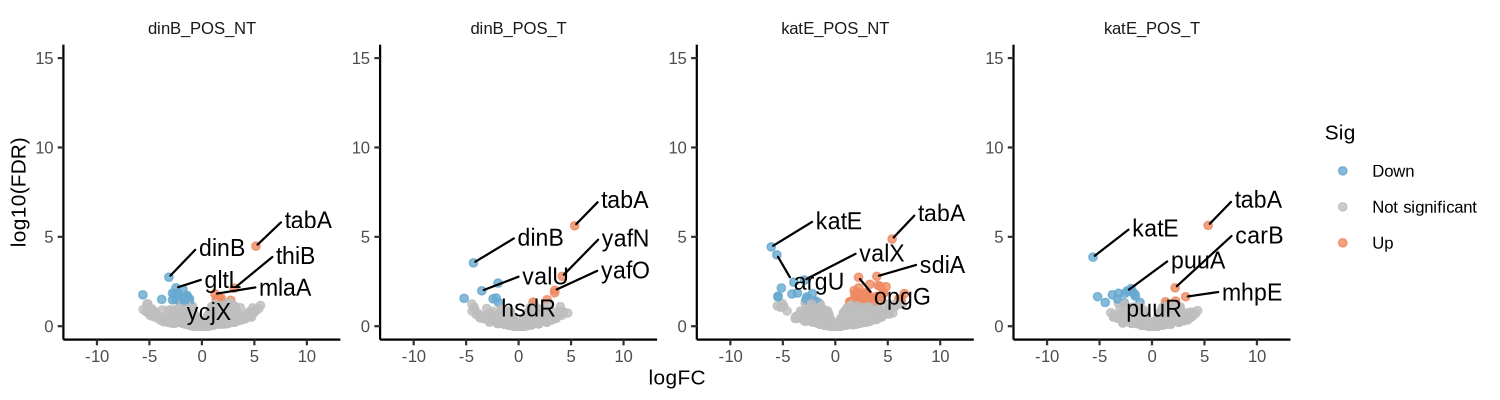

In [17]:
%%R -i df_tr  -w 1500 -h 400 -r 150 
plot_df_tr(df_tr)

### Go plot

Plots significant GO terms. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same GO term that were significant. Example: if Go term X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

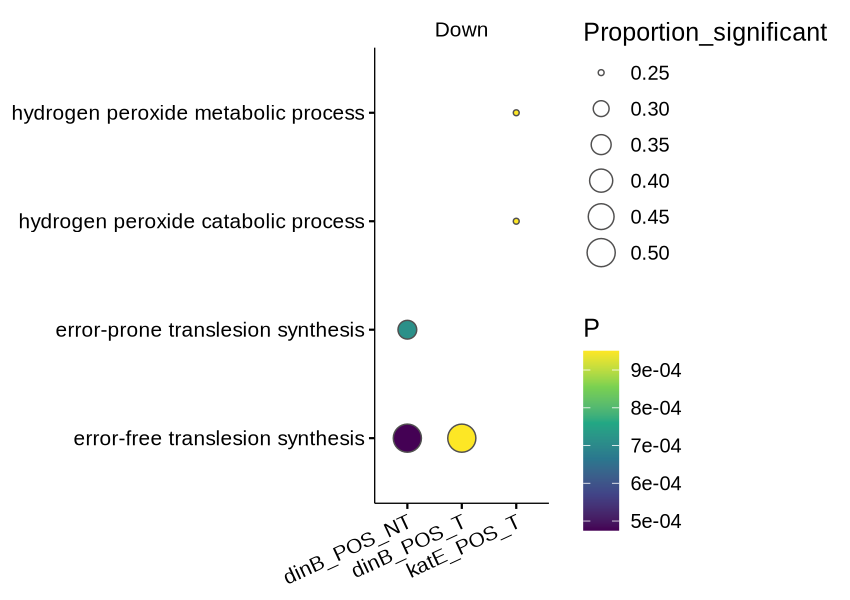

In [18]:
%%R  -w 850 -h 600 -r 150 -i df_go

plot_df_go(df_go)

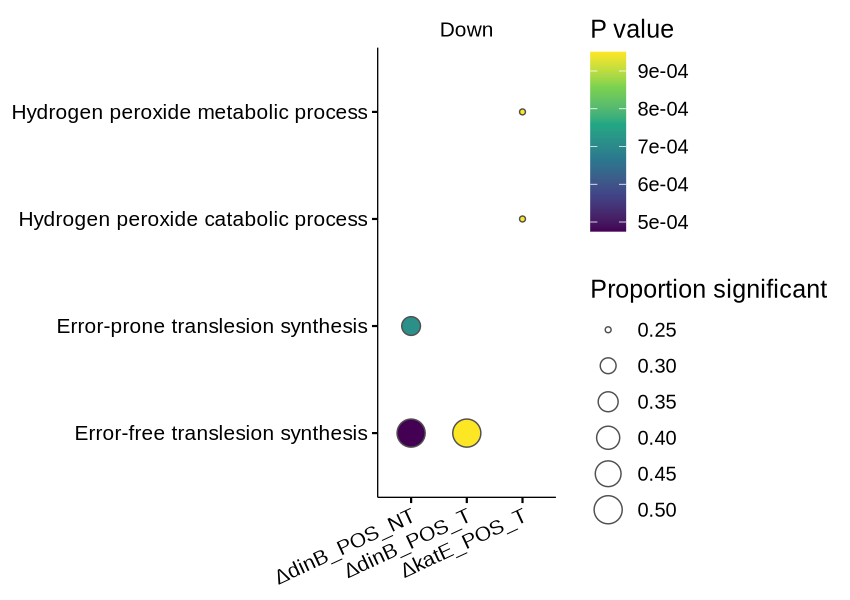

In [19]:
%%R  -w 850 -h 600 -r 150 -i df_go

library(ggtext)
library(glue)
library(stringi)

plot_df_go <- function(df) {
  # Function to italicize gene names
  italicize_gene <- function(x, gene) {
    pattern <- paste0("(\\b", gene, "\\b)")
    replacement <- paste0("<i>\\1</i>")
    str_replace(x, pattern, replacement)
  }

  # Modify and prepare data
  df <- df %>%
    mutate(
      First = case_when(
        str_detect(First, "dinB|katE") ~ paste0("\u0394", First),
        First == "_POS_" ~ " ",
        TRUE ~ First
      ),
      First = italicize_gene(First, "\u0394dinB"),
      First = italicize_gene(First, "\u0394katE"),
      Term = str_to_sentence(Term)
    )

  # Create the plot
  p <- df %>%
    filter(P <= 0.001, Ont == 'BP') %>%
    ggplot(aes(x = First, y = Term, size = Proportion_significant, fill = P)) +
    geom_point(shape = 21, color = '#515050') +
    facet_wrap(~Direction) +
    scale_fill_viridis_c(name = "P value") +
    scale_size(name = "Proportion significant") +
    theme(
      text = element_text(size = 12),
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black", size = 10),
      panel.spacing = unit(0.5, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line.y = element_line(size = 0.3, colour = 'black'),
      axis.line.x = element_line(size = 0.3, colour = "black"),
      panel.background = element_rect(fill = 'white'),
      axis.text.y = element_text(color = "black", size = 10),
      axis.text.x = element_markdown(color = "black", angle = 25, hjust = 1, size = 10),
      axis.ticks = element_line(color = 'black'),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major.y = element_line(colour = NA),
      panel.grid.major.x = element_blank()
    )
  
  return(p)
}
plot_df_go(df_go)

### KEGG plot

Plots significant KEGG pathways. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same KEGG pathways that were significant. Example: if a KEGG pathway X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

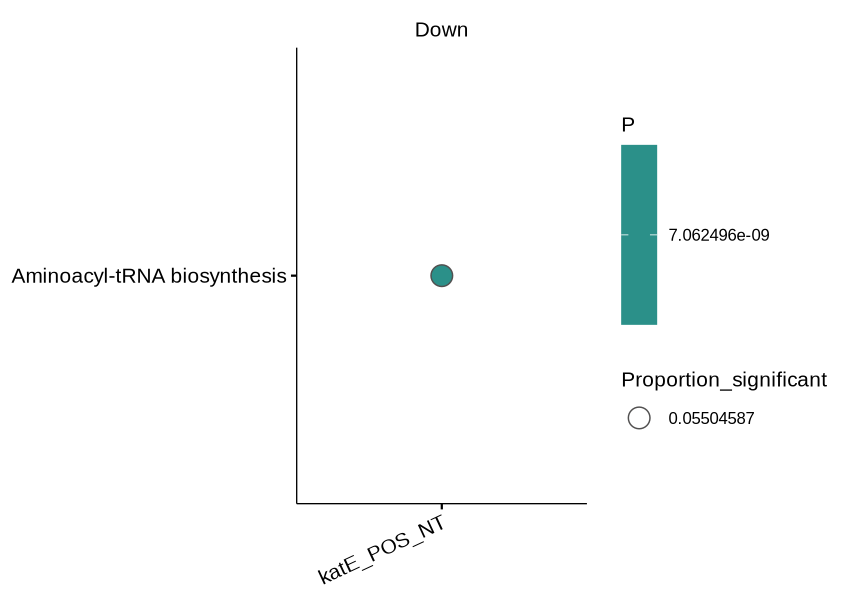

In [20]:
%%R  -w 850 -h 600 -r 150 -i df_kegg
plot_df_kegg(df_kegg)

### Venn Diagram

Venn Diagram of overlapping and unique genes / GO terms / KEGG pathways for each comparison.

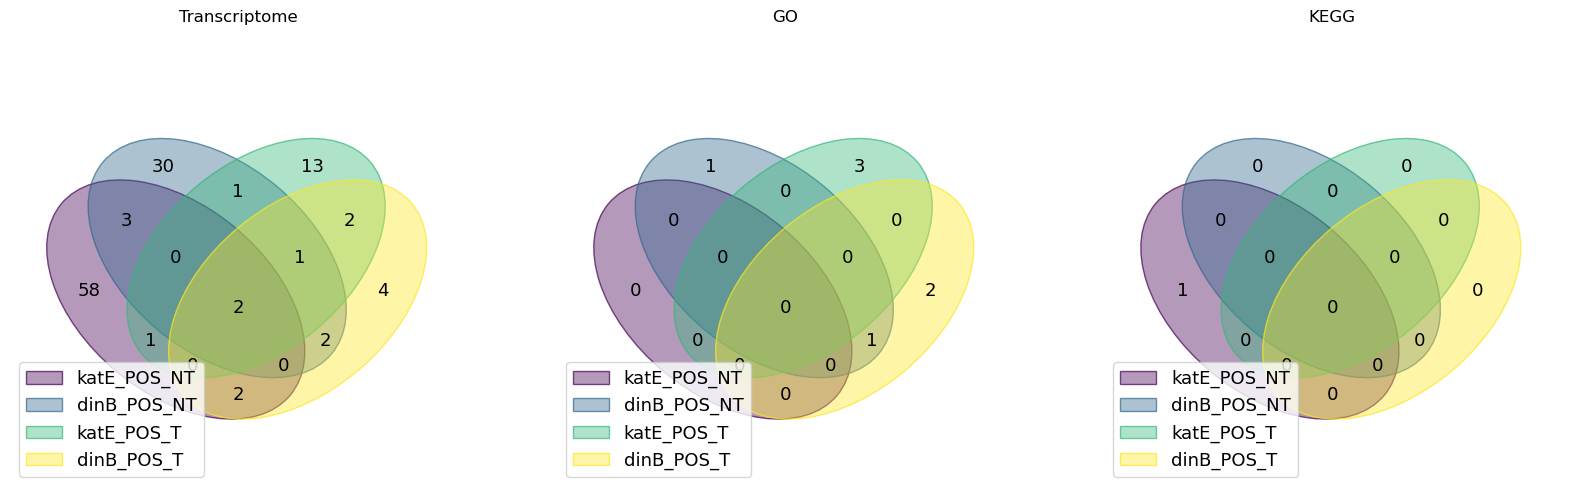

In [21]:
create_and_plot_venn(df_tr, df_go, df_kegg)

### Data Table

1. Transcriptome data

Only genes with FDR below or equal to 0.05 are included in the table. You can search for genes in the search field. 

2. Go terms

Only GO terms  below or equal to 0.001 are included in the table. You can search for Go terms in the search field. 

3. KEGG pathways

Only KEGG pathways below or equal to 0.001 are included in the table. 

If you want to download the data press either the ``CSV`` or ``Excel`` button. 

In [22]:
plot_table(df_tr[df_tr.label != "Non-significant"][["logFC", "logCPM", "gene_name", "First", "Second", 'FDR', 'label']], "transcriptome_1")

In [23]:
plot_table(df_go[df_go['P'] < 0.05][["Term", "Ont", "N", "Significant", "P", "First","Second", "Direction"]], "Go_1")

In [24]:
plot_table(df_kegg[df_kegg['P'] < 0.05][["Pathway", "N", "Significant", "P", "First", "Second", "Direction"]], "KEGG_1")

## 2. Compare Susceptible to Evolved Strains

How does the adaptation/evolution/mutations influence the transcriptome?
- MG1655 (S-NT) vs. MG1655 (E-NT)
- dinB (S-NT) vs. dinB (E-NT)
- katE (S-NT) vs. katE (E-NT)

E-NT = AMO_NT

### Significance table

This table contains the number of significant "entities" per analysis, as well as if they were up or down regulated.  

Bellow are the groups which were compared. You can see the order as `treated` vs `control`. 

In [25]:
"""
Clean data and return a table of nr significant entities per group.
"""
warnings.filterwarnings('ignore')

question = '2'
df_tr_2, df_kegg_2, df_go_2 = python_parse(df_all_tr[df_all_tr.Question == question],
                                     df_all_go[df_all_go.Question == question],
                                     df_all_kegg[df_all_kegg.Question == question])

print("Compared groups")

for index, row in df_tr_2[['First', 'Second']].drop_duplicates().iterrows():
    print(f"{row['First']} VS {row['Second']}")

| Analysis Type      |   Number of Significant Results |
|:-------------------|--------------------------------:|
| KEGG Up            |                              18 |
| KEGG Down          |                               6 |
| GO Up              |                             263 |
| GO Down            |                              20 |
| Transcriptome Up   |                             400 |
| Transcriptome Down |                             430 |

Compared groups
MG1655_AMO_NT VS MG1655_POS_NT
katE_AMO_NT VS katE_POS_NT
dinB_AMO_NT VS dinB_POS_NT


### Volcano plot

Volcano plot for transcriptomic data. The top 3 up and down regulated genes are labeled.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


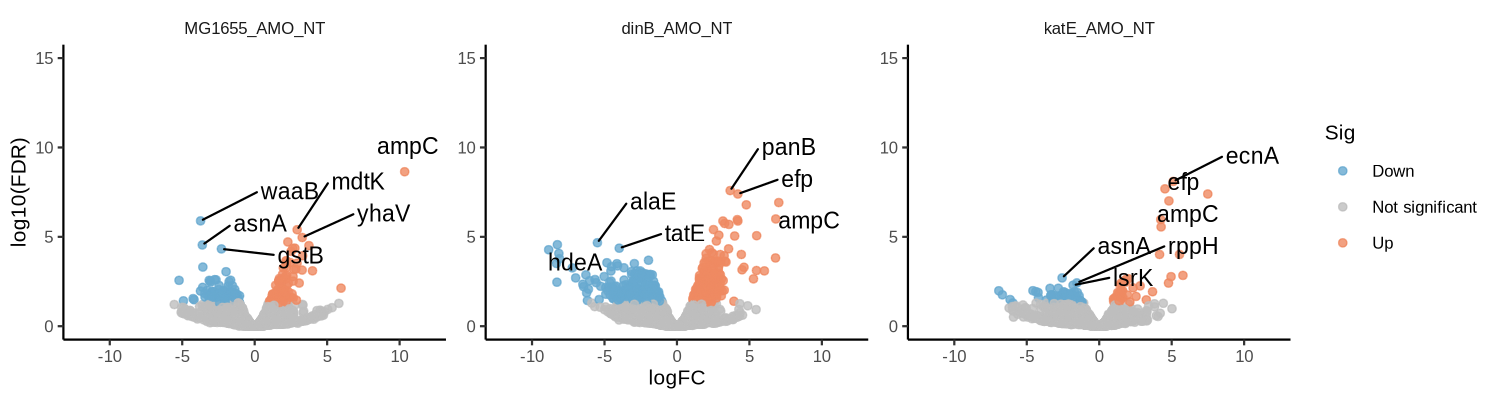

In [26]:
%%R -i df_tr_2  -w 1500 -h 400 -r 150 
plot_df_tr(df_tr_2)

### Go plot

Plots significant GO terms. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same GO term that were significant. Example: if Go term X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

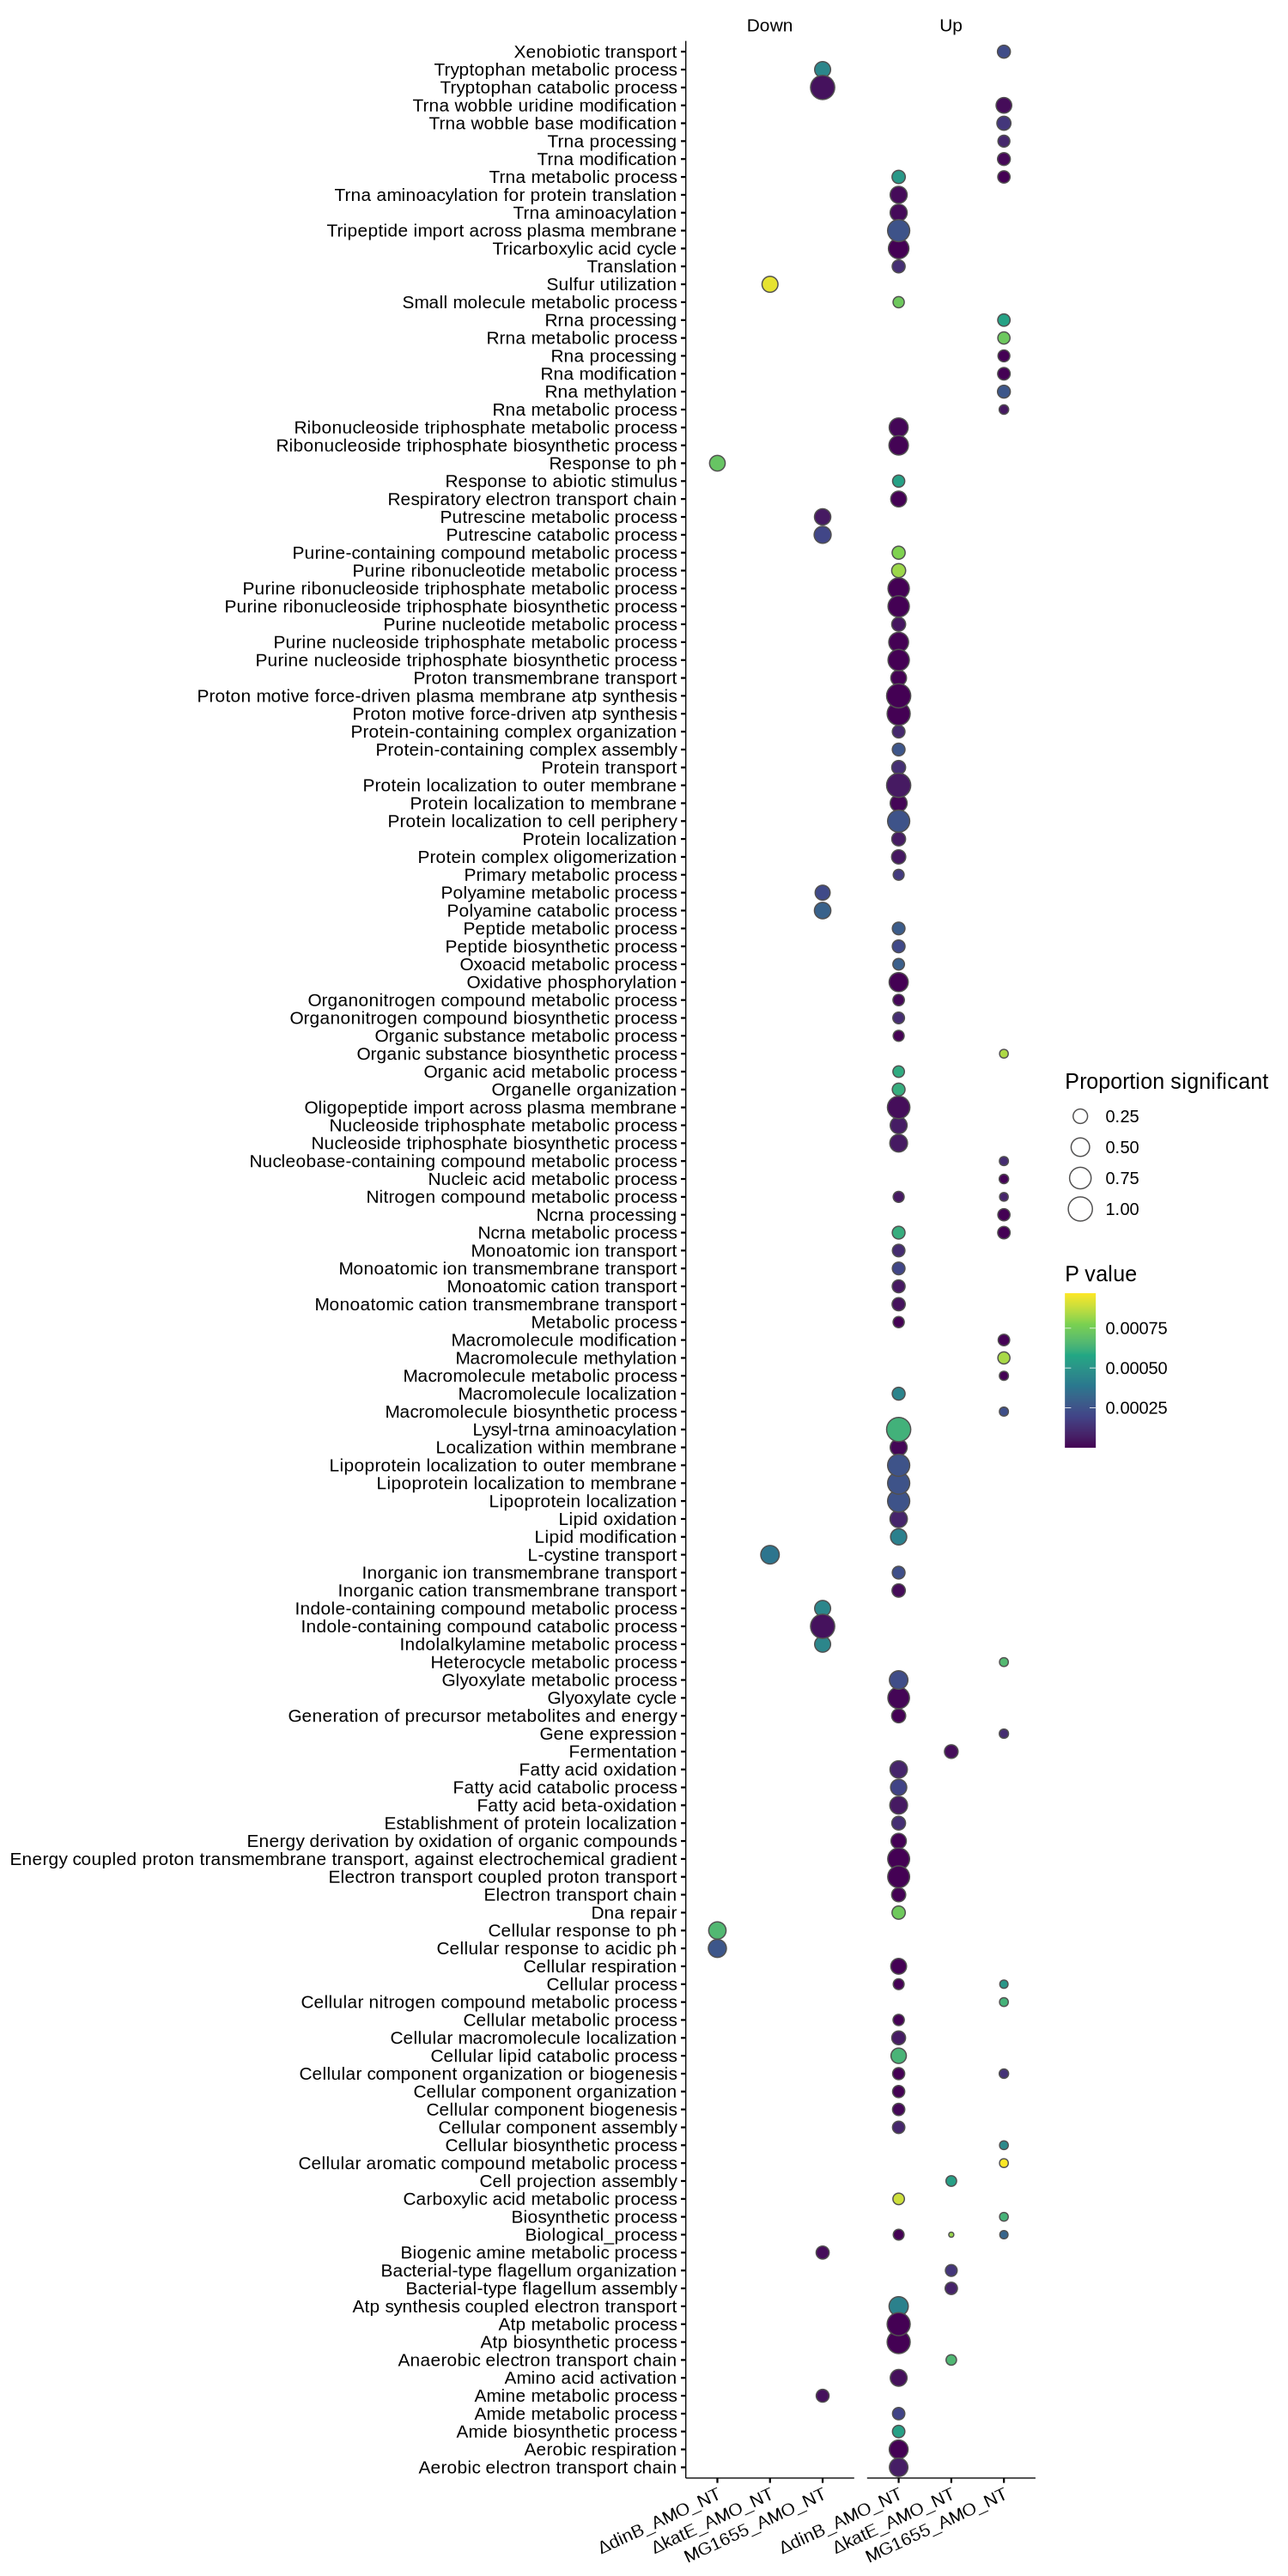

In [27]:
%%R -i df_go_2  -w 1500 -h 3000 -r 150 
plot_df_go(df_go_2)

### KEGG plot

Plots significant KEGG pathways. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same KEGG pathways that were significant. Example: if a KEGG pathway X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

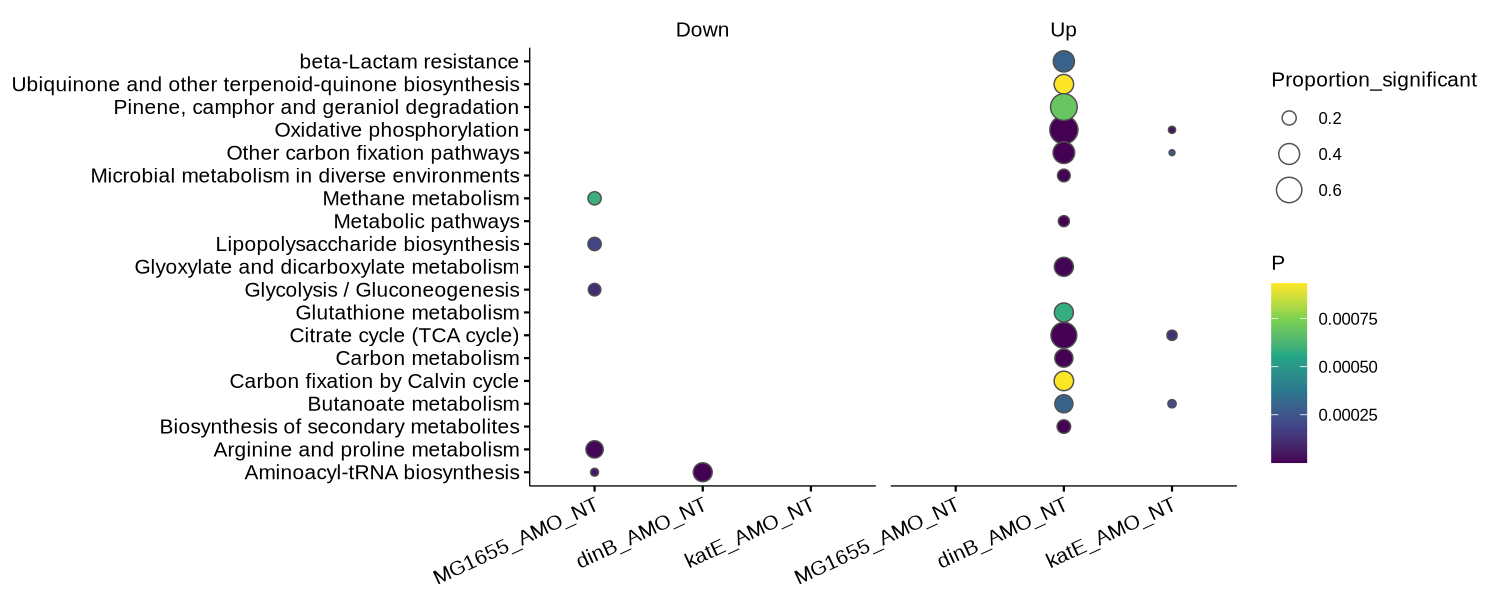

In [28]:
%%R  -w 1500 -h 600 -r 150 -i df_kegg_2
plot_df_kegg(df_kegg_2)

### Venn Diagram

Venn Diagram of overlapping and unique genes / GO terms / KEGG pathways for each comparison.

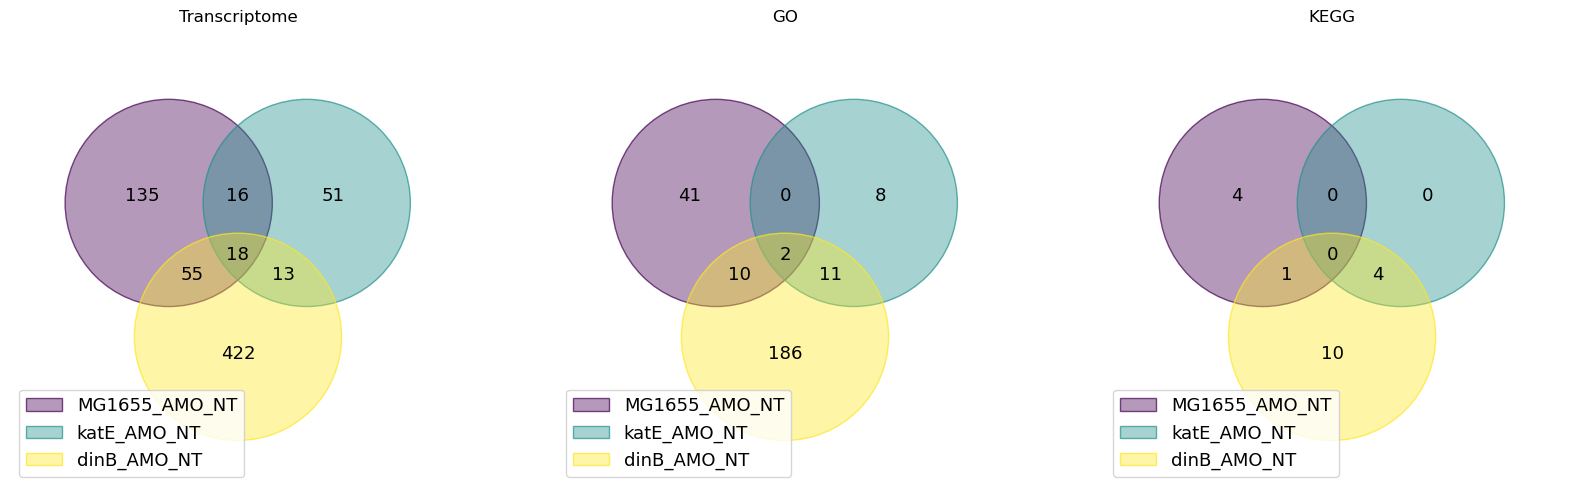

In [29]:
create_and_plot_venn(df_tr_2, df_go_2, df_kegg_2)

### Data Table

1. Transcriptome data

Only genes with FDR below or equal to 0.05 are included in the table. You can search for genes in the search field. 

2. Go terms

Only GO terms  below or equal to 0.001 are included in the table. You can search for Go terms in the search field. 

3. KEGG pathways

Only KEGG pathways below or equal to 0.001 are included in the table. 

If you want to download the data press either the ``CSV`` or ``Excel`` button. 

In [30]:
plot_table(df_tr_2[df_tr_2.label != "Non-significant"][["logFC", "logCPM", "gene_name", "First","Second", 'FDR', 'label']], "Transcriptomics_2")

In [31]:
plot_table(df_go_2[df_go_2['P'] < 0.05][["Term", "Ont", "N", "Significant", "P", "First","Second", "Direction"]], "Go_2")

In [32]:
plot_table(df_kegg_2[df_kegg_2['P'] < 0.05][["Pathway", "N", "Significant", "P", "First", "Second", "Direction"]], "KEGG_1")

## 3. Compare Evolved Trajectories

Check for commonalities and differences (Venn diagram)
- MG1655 (E-NT) vs. katE (E-NT)
- MG1655 (E-T) vs. katE (E-T)
- MG1655 (E-NT) vs. dinB (E-NT)
- MG1655 (E-T) vs. dinB (E-T)

### Significance table

This table contains the number of significant "entities" per analysis, as well as if they were up or down regulated.  

Bellow are the groups which were compared. You can see the order as `treated` vs `control`. 

In [33]:
"""
Clean data and return a table of nr significant entities per group.
"""
warnings.filterwarnings('ignore')

question = '3'
df_tr_3, df_kegg_3, df_go_3 = python_parse(df_all_tr[df_all_tr.Question == question],
                                     df_all_go[df_all_go.Question == question],
                                     df_all_kegg[df_all_kegg.Question == question])

print("Compared groups")

for index, row in df_tr_3[['First', 'Second']].drop_duplicates().iterrows():
    print(f"{row['First']} VS {row['Second']}")

| Analysis Type      |   Number of Significant Results |
|:-------------------|--------------------------------:|
| KEGG Up            |                              21 |
| KEGG Down          |                               6 |
| GO Up              |                             206 |
| GO Down            |                             105 |
| Transcriptome Up   |                             403 |
| Transcriptome Down |                             503 |

Compared groups
katE_AMO_NT VS MG1655_AMO_NT
katE_AMO_T VS MG1655_AMO_T
dinB_AMO_NT VS MG1655_AMO_NT
dinB_AMO_T VS MG1655_AMO_T


### Volcano plot

Volcano plot for transcriptomic data. The top 3 up and down regulated genes are labeled.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


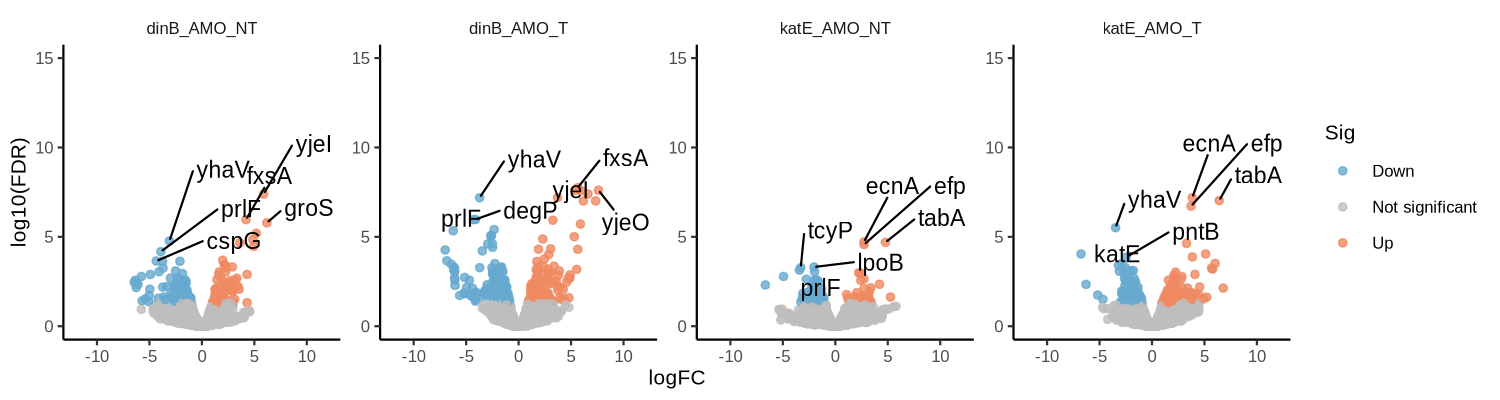

In [34]:
%%R -i df_tr_3  -w 1500 -h 400 -r 150 
plot_df_tr(df_tr_3)

### Go plot

Plots significant GO terms. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same GO term that were significant. Example: if Go term X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

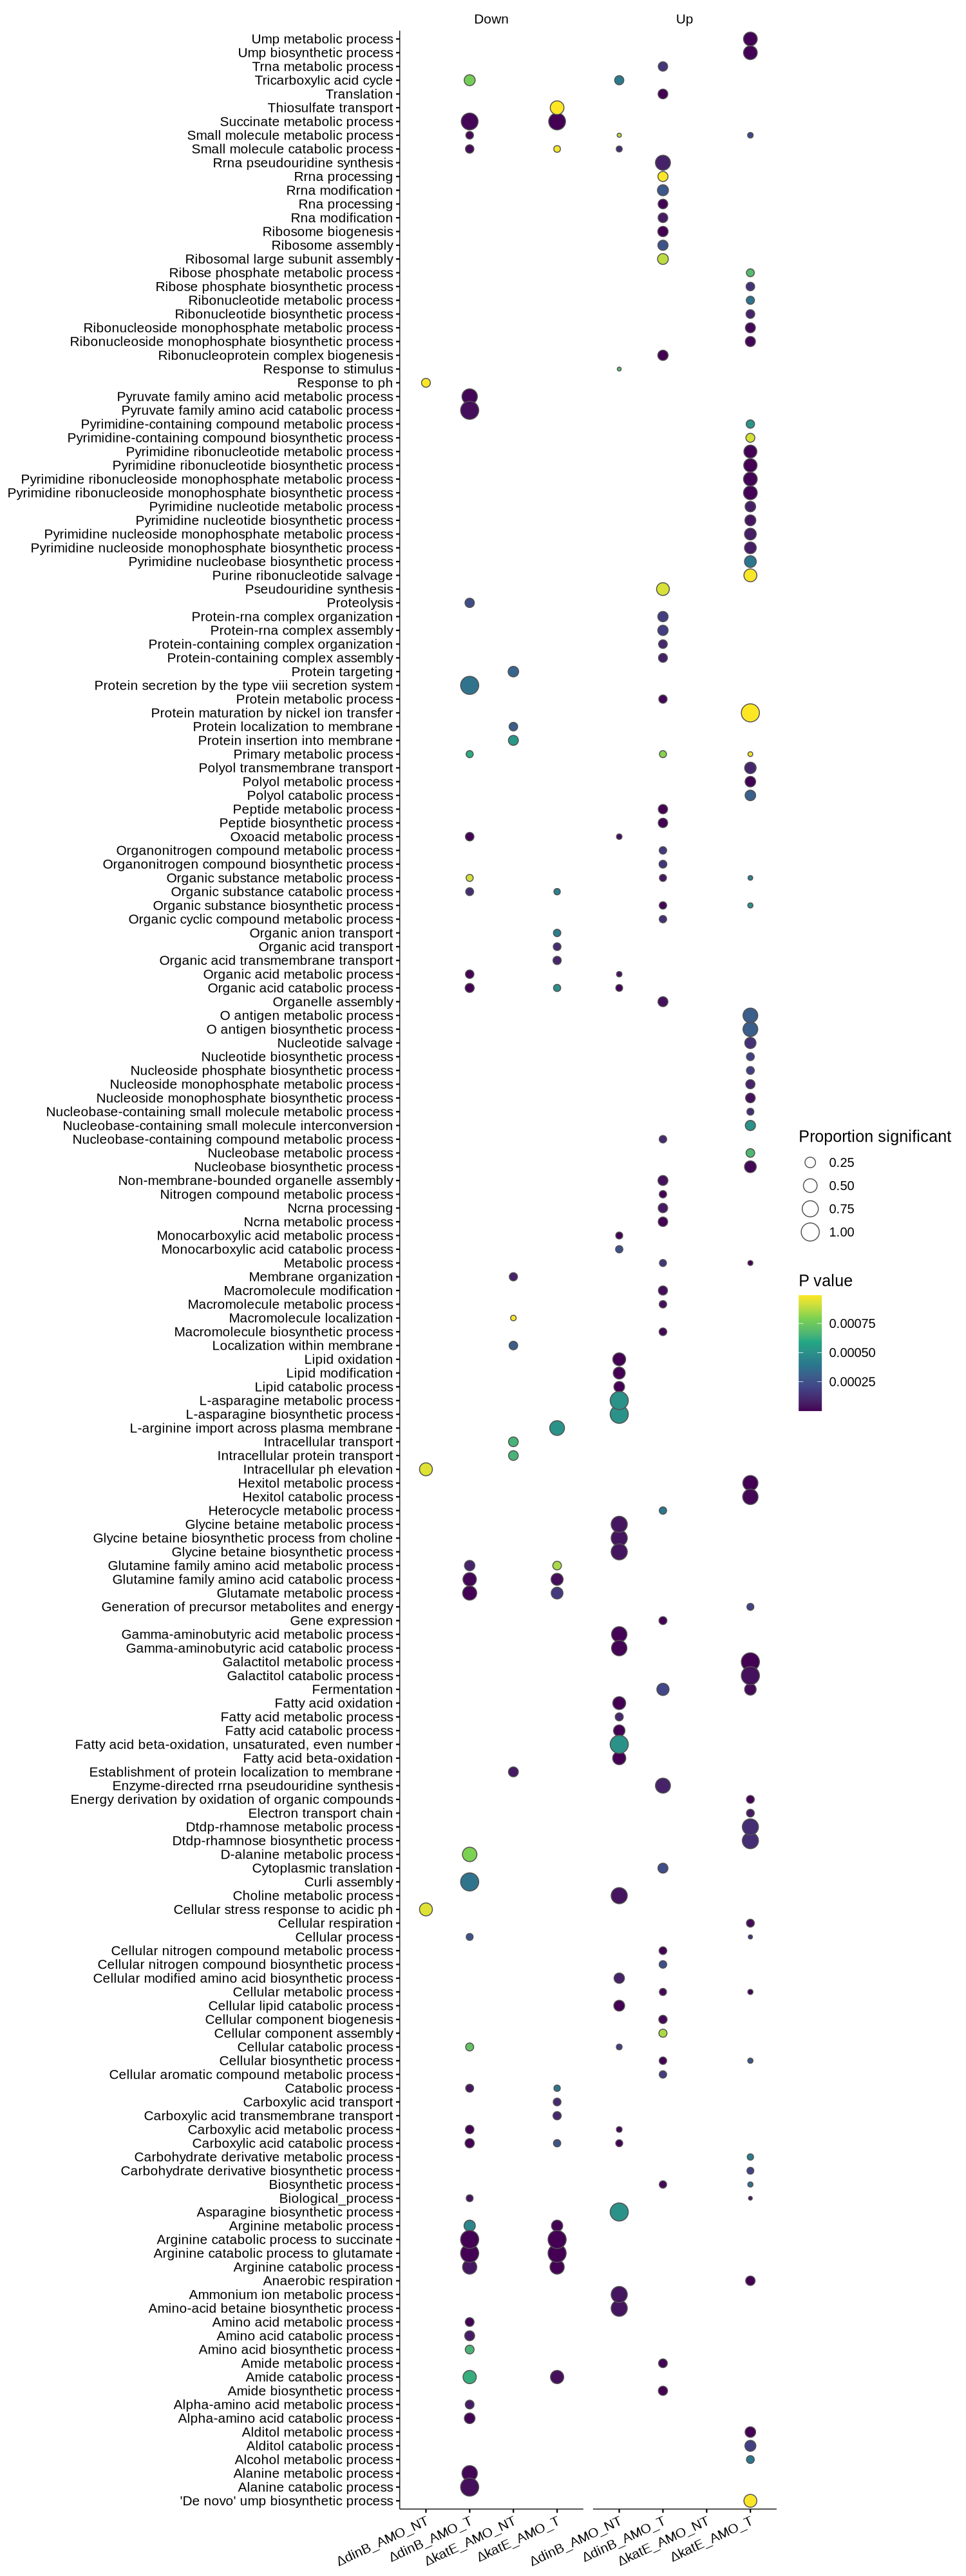

In [35]:
%%R -i df_go_3 -w 1500 -h 4000 -r 150 

plot_df_go(df_go_3)

### KEGG plot

Plots significant KEGG pathways. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same KEGG pathways that were significant. Example: if a KEGG pathway X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

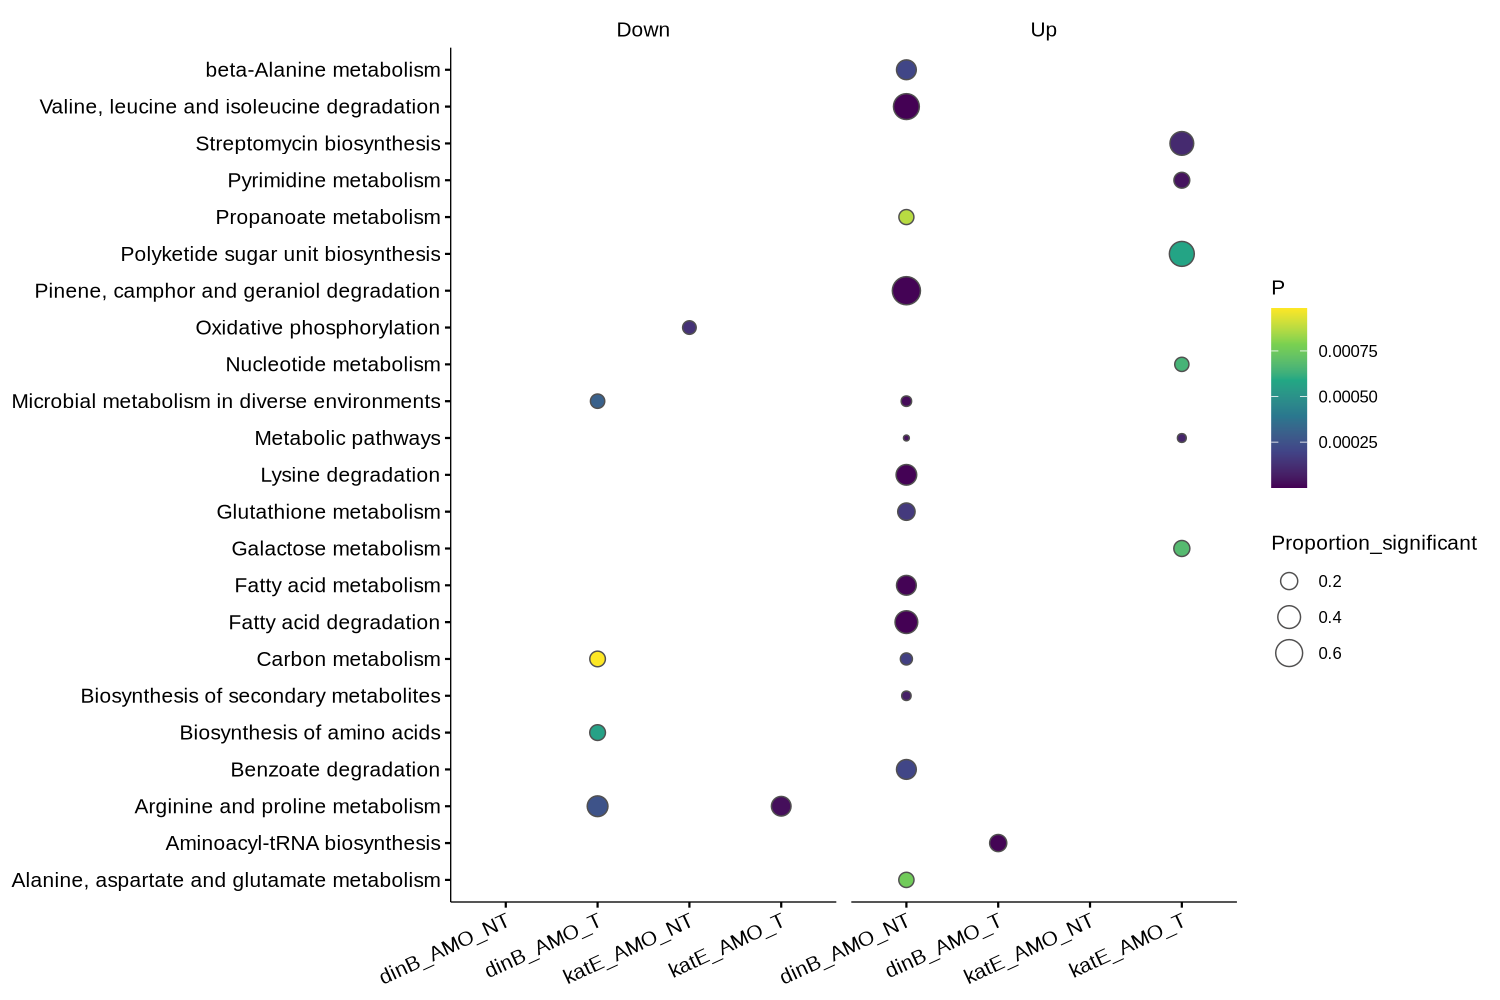

In [36]:
%%R  -w 1500 -h 1000 -r 150 -i df_kegg_3
plot_df_kegg(df_kegg_3)

### Venn Diagram

Venn Diagram of overlapping and unique genes / GO terms / KEGG pathways for each comparison.

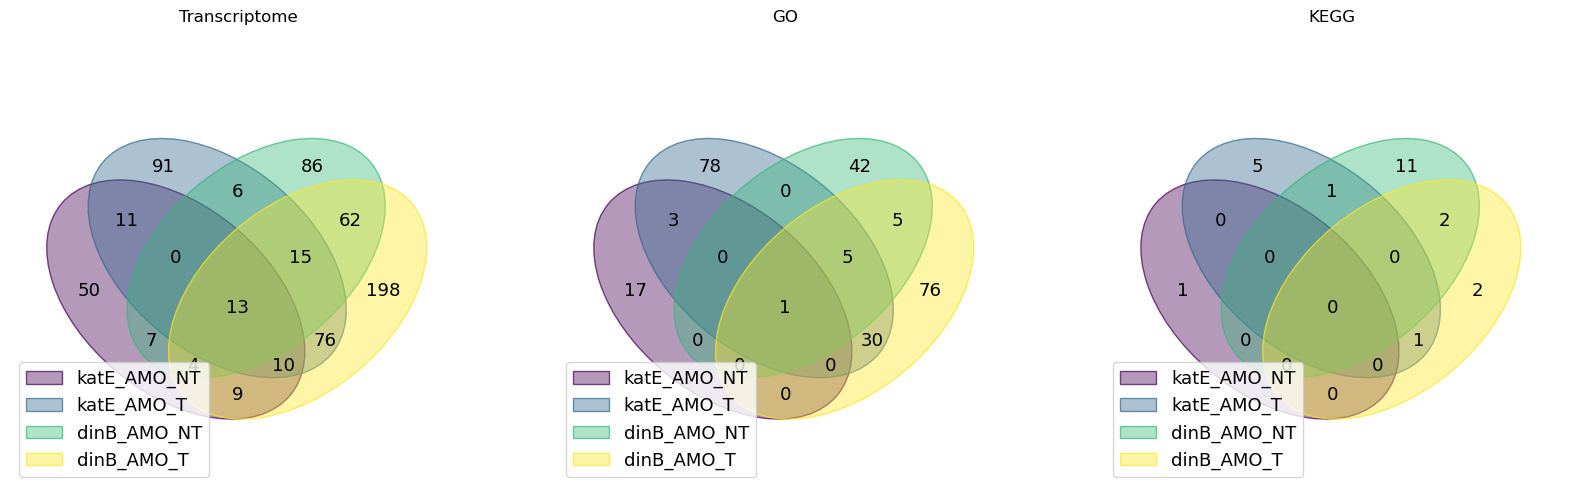

In [37]:
create_and_plot_venn(df_tr_3, df_go_3, df_kegg_3)

In [38]:
plot_table(df_tr_3[df_tr_3.label != "Non-significant"][["logFC", "logCPM", "gene_name", "First","Second", 'FDR', 'label']], "Transcriptomics_3")

### Data Table

1. Transcriptome data

Only genes with FDR below or equal to 0.05 are included in the table. You can search for genes in the search field. 

2. Go terms

Only GO terms  below or equal to 0.001 are included in the table. You can search for Go terms in the search field. 

3. KEGG pathways

Only KEGG pathways below or equal to 0.001 are included in the table. 

If you want to download the data press either the ``CSV`` or ``Excel`` button. 

In [39]:
plot_table(df_go_3[df_go_3['P'] < 0.05][["Term", "Ont", "N", "Significant", "P", "First","Second", "Direction"]], "Go_3")

In [40]:
plot_table(df_kegg_3[df_kegg_3['P'] < 0.05][["Pathway", "N", "Significant", "P", "First", "Second", "Direction"]], "KEGG_3")

## 4. Compare Transcriptome Under Treatment

- MG1655 NT vs. T (E-NT vs. E-T)
- dinB NT vs. T
- katE NT vs. T

E-NT = AMO_NT \
E-T = AMO_T

### Significance table

This table contains the number of significant "entities" per analysis, as well as if they were up or down regulated.  

Bellow are the groups which were compared. You can see the order as `treated` vs `control`. 

In [41]:
"""
Clean data and return a table of nr significant entities per group.
"""
warnings.filterwarnings('ignore')

question = '4'
df_tr_4, df_kegg_4, df_go_4 = python_parse(df_all_tr[df_all_tr.Question == question],
                                     df_all_go[df_all_go.Question == question],
                                     df_all_kegg[df_all_kegg.Question == question])

print("Compared groups")

for index, row in df_tr_4[['First', 'Second']].drop_duplicates().iterrows():
    print(f"{row['First']} VS {row['Second']}")

| Analysis Type      |   Number of Significant Results |
|:-------------------|--------------------------------:|
| KEGG Up            |                              11 |
| KEGG Down          |                               8 |
| GO Up              |                              79 |
| GO Down            |                              74 |
| Transcriptome Up   |                             158 |
| Transcriptome Down |                             115 |

Compared groups
MG1655_AMO_T VS MG1655_AMO_NT
dinB_AMO_T VS dinB_AMO_NT
katE_AMO_T VS katE_AMO_NT


### Volcano plot

Volcano plot for transcriptomic data. The top 3 up and down regulated genes are labeled.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


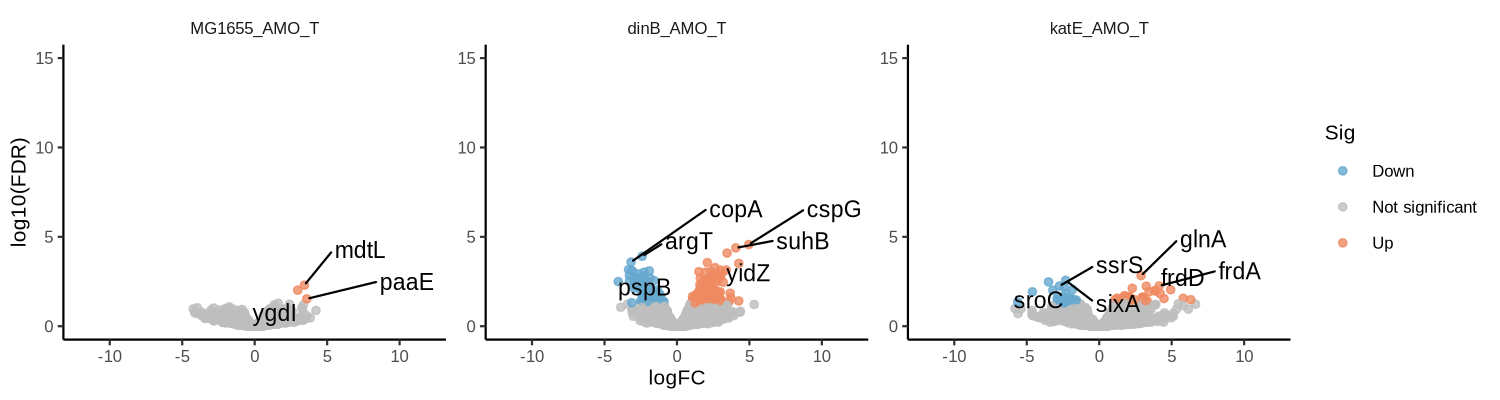

In [42]:
%%R -i df_tr_4  -w 1500 -h 400 -r 150 
plot_df_tr(df_tr_4)

### Go plot

Plots significant GO terms. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same GO term that were significant. Example: if Go term X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

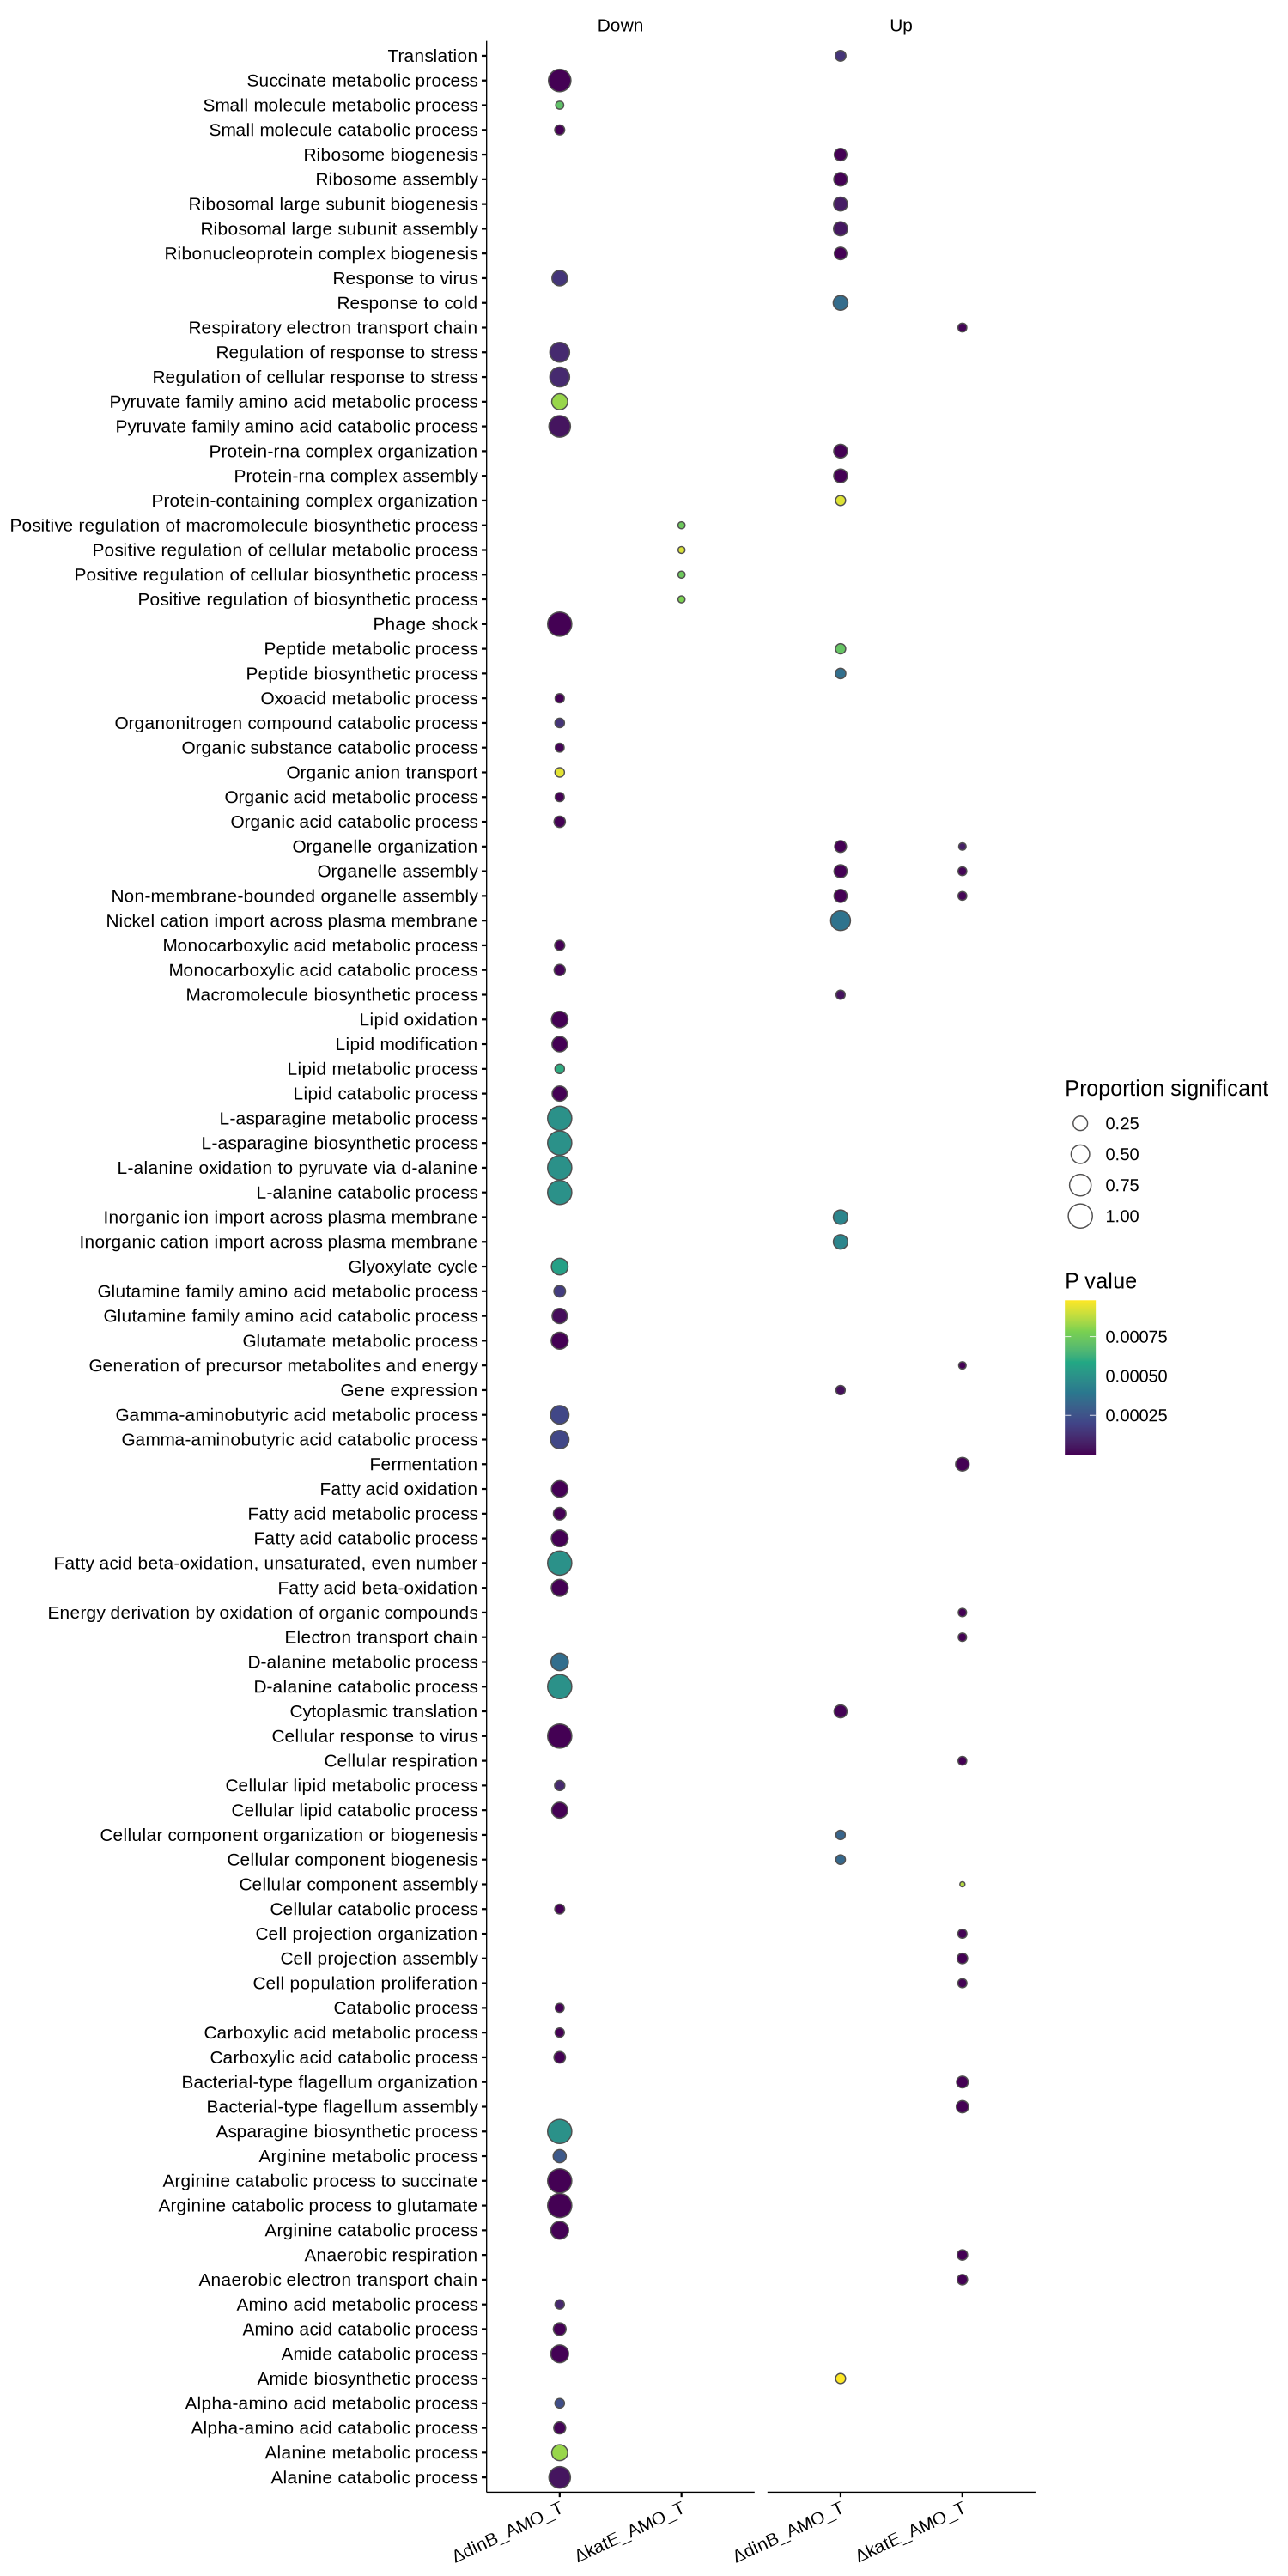

In [43]:
%%R -i df_go_4 -w 1500 -h 3000 -r 150 

plot_df_go(df_go_4)

### KEGG plot

Plots significant KEGG pathways. Ths colors indicate the level of FDR corrected p-value and the size the proportion of genes with same KEGG pathways that were significant. Example: if a KEGG pathway X has 10 genes in it, and 5 are significant the value would be calculated by 5/10 = 0.5. 

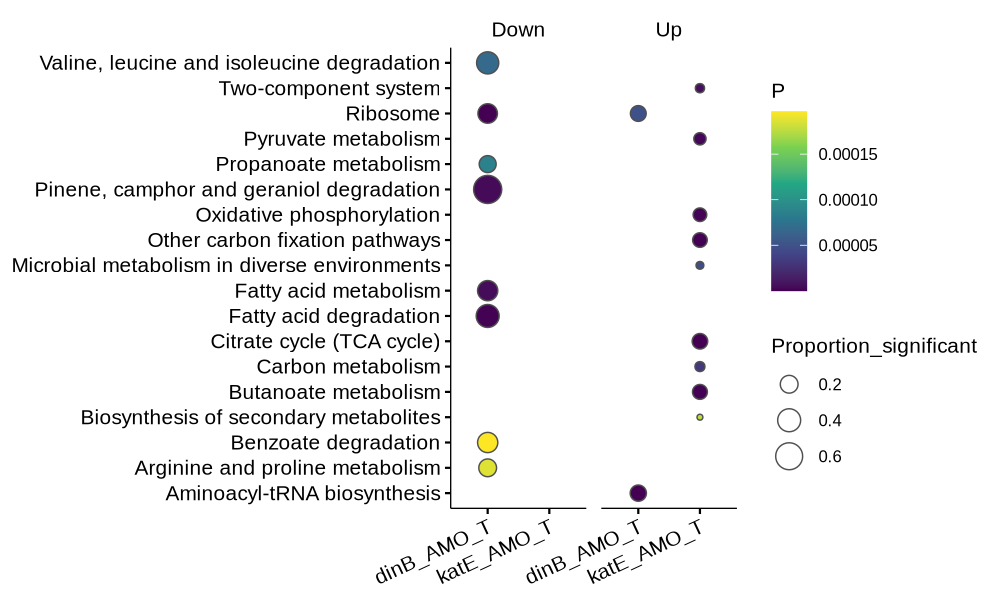

In [44]:
%%R  -w 1000 -h 600 -r 150 -i df_kegg_4
plot_df_kegg(df_kegg_4)

### Venn Diagram

Venn Diagram of overlapping and unique genes / GO terms / KEGG pathways for each comparison.

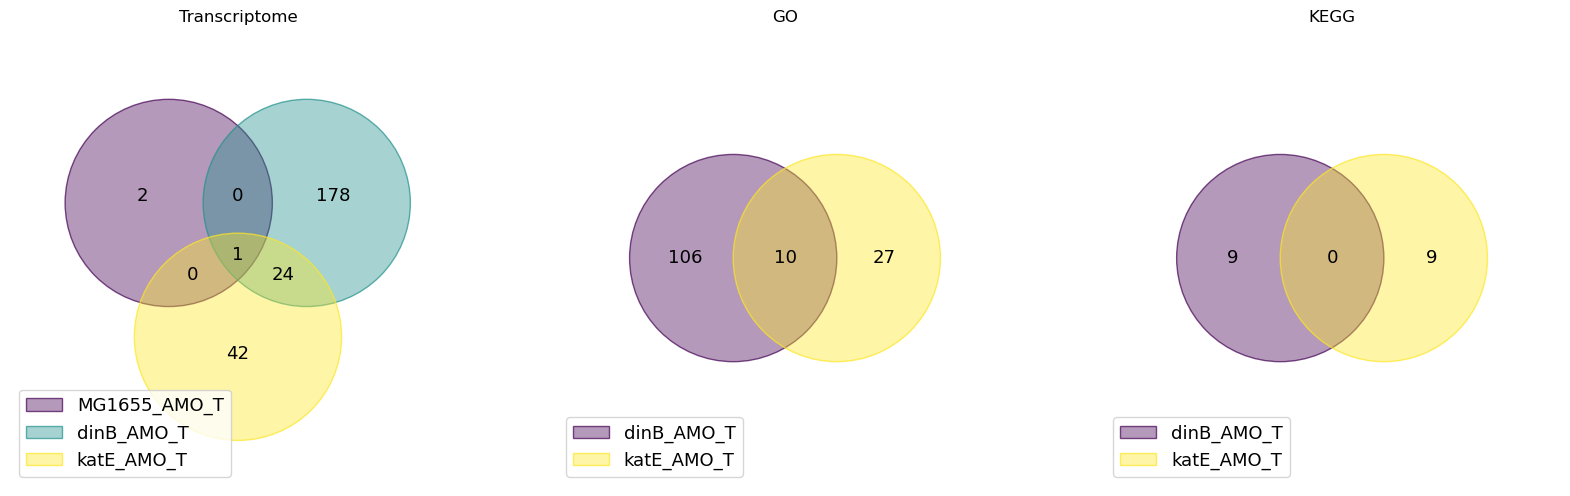

In [45]:
create_and_plot_venn(df_tr_4, df_go_4, df_kegg_4)

### Data Table

1. Transcriptome data

Only genes with FDR below or equal to 0.05 are included in the table. You can search for genes in the search field. 

2. Go terms

Only GO terms  below or equal to 0.001 are included in the table. You can search for Go terms in the search field. 

3. KEGG pathways

Only KEGG pathways below or equal to 0.001 are included in the table. 

If you want to download the data press either the ``CSV`` or ``Excel`` button. 

In [46]:
plot_table(df_tr_4[df_tr_4.label != "Non-significant"][["logFC", "logCPM", "gene_name", "First","Second", 'FDR', 'label']], "Transcriptomics_4")

In [47]:
plot_table(df_go_4[df_go_4['P'] < 0.05][["Term", "Ont", "N", "Significant", "P", "First","Second", "Direction"]], "Go_4")

In [48]:
plot_table(df_kegg_4[df_kegg_4['P'] < 0.05][["Pathway", "N", "Significant", "P", "First", "Second", "Direction"]], "KEGG_4")

## Mutation analysis

In [49]:
df_bw_mut = pd.read_csv("data/DNA/pipeline/breseq_compare/BW/compare_BW.tsv", sep = "\t")
df_mg_mut = pd.read_csv("data/DNA/pipeline/breseq_compare/MG/compare_MG.tsv", sep = "\t")

df_bw_mut["Strain"] = "BW"
df_mg_mut["Strain"] = "MG"

df_mut = pd.concat([df_bw_mut, df_mg_mut])

# Exclude technical replicates
df_mut = df_mut[~df_mut.title.isin(['S11_MG1655_WT@Start_Second', 'S12_MG1655_WT@End_Second','S1_MG1655_WT@Start_First', 'S2_MG1655_WT@End_First', 'S3_MG1655_AMO_First'])]

In [50]:
print(f"These are the files included in the genome analyses. First and Second refers to sampling round: \n{df_mut.title.unique()}")

These are the files included in the genome analyses. First and Second refers to sampling round: 
['S13_dinB_WT@Start_Second' 'S14_dinB_WT@End_Second'
 'S15_dinB_WT@End_Second' 'S16_katE_WT@Start_Second'
 'S17_katE_WT@End_Second' 'S18_katE_WT@End_Second'
 'S19_dinB_WT@Start_First' 'S20_dinB_WT@End_First' 'S21_dinB_AMO_First'
 'S22_dinB_AMO_Second' 'S23_dinB_AMO_Second' 'S24_katE_AMO_Second'
 'S25_katE_AMO_Second' 'S25_katE_WT@Start_First' 'S26_katE_WT@End_First'
 'S27_katE_AMO_First' 'S19_MG1655_WT@Start_Second'
 'S20_MG1655_WT@End_Second' 'S21_MG1655_WT@End_Second'
 'S26_MG1655_AMO_Second' 'S27_MG1655_AMO_Second'
 'S7_MG1655_WT@Start_First' 'S8_MG1655_WT@End_First' 'S9_MG1655_AMO_First']


In [51]:
df_mut.title.value_counts()

title
S22_dinB_AMO_Second           56
S17_katE_WT@End_Second        45
S21_MG1655_WT@End_Second      40
S15_dinB_WT@End_Second        37
S20_MG1655_WT@End_Second      34
S26_MG1655_AMO_Second         27
S9_MG1655_AMO_First           26
S18_katE_WT@End_Second        24
S14_dinB_WT@End_Second        23
S27_MG1655_AMO_Second         23
S27_katE_AMO_First            22
S13_dinB_WT@Start_Second      22
S24_katE_AMO_Second           20
S25_katE_AMO_Second           20
S20_dinB_WT@End_First         20
S7_MG1655_WT@Start_First      18
S8_MG1655_WT@End_First        18
S19_MG1655_WT@Start_Second    16
S21_dinB_AMO_First            16
S26_katE_WT@End_First         16
S19_dinB_WT@Start_First       15
S16_katE_WT@Start_Second      13
S25_katE_WT@Start_First       13
S23_dinB_AMO_Second           13
Name: count, dtype: int64

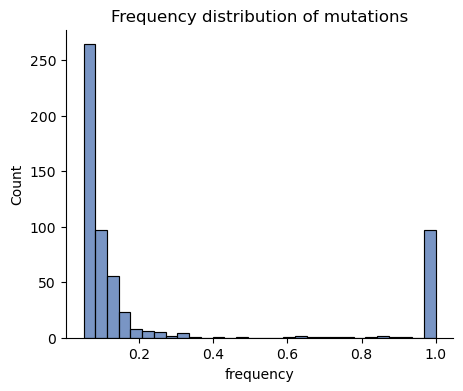

In [52]:
sns.set_palette("deep")  # Set the color palette to "deep"

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
sns.histplot(data=df_mut, x="frequency", bins=30, ax=ax1).set(title='Frequency distribution of mutations')
sns.despine()
plt.savefig('documentation/RNA/scientific_questions/plots/mutation_frequency_distribution.png', dpi=300, bbox_inches='tight')

In [53]:
df_mut['Sample_cleaned'] = df_mut['title'].str.replace(r'^S\d+_', '', regex=True).str.replace(".hits", "")
df_mut['Sample_cleaned'] = df_mut['Sample_cleaned'].str.replace('_Second', '', regex=False)
df_mut['Sample_cleaned'] = df_mut['Sample_cleaned'].str.replace('_First', '', regex=False)

df_mut['Type'] = np.where(df_mut['Sample_cleaned'].str.contains('@Start'), 'WT_Start',
                     np.where(df_mut['Sample_cleaned'].str.contains('AMO'), 'AMO',
                     np.where(df_mut['Sample_cleaned'].str.contains('@End'), 'WT_End', '')))


sample_mut = df_mut[["title", "Sample_cleaned"]].drop_duplicates().Sample_cleaned.value_counts().reset_index()
sample_mut

Sample_cleaned  count
0      dinB_WT@End      3
1       MG1655_AMO      3
2      katE_WT@End      3
3         dinB_AMO      3
4         katE_AMO      3
5    MG1655_WT@End      3
6    dinB_WT@Start      2
7    katE_WT@Start      2
8  MG1655_WT@Start      2

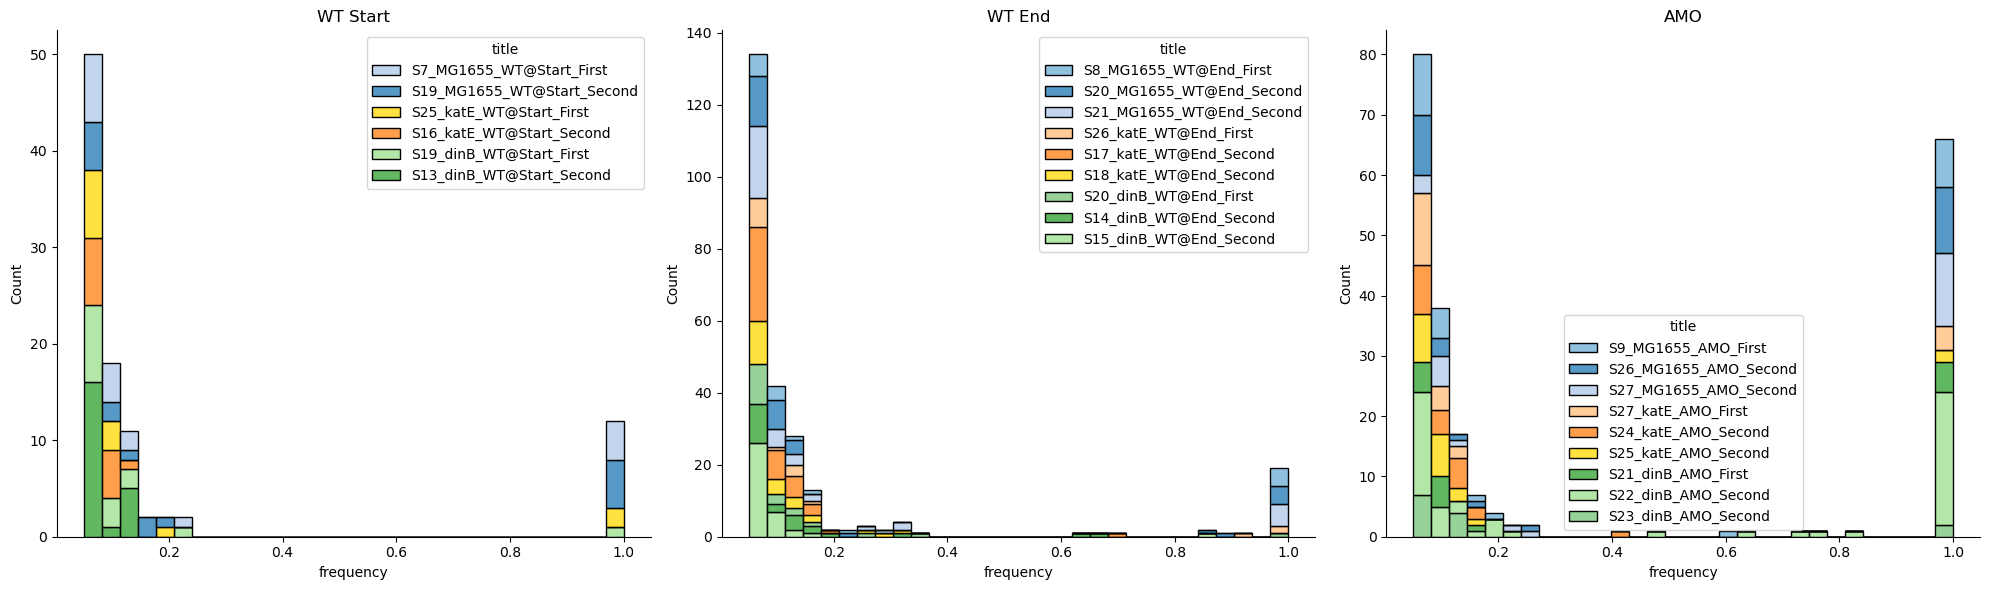

In [54]:
# Define base colors for each main group
base_colors = {
    'MG1655': '#1f77b4',  # Blue
    'katE': '#ff7f0e',    # Orange
    'dinB': '#2ca02c'     # Green
}

# Color dictionaries for each plot
wt_start_colors = {
    'S13_dinB_WT@Start_Second': base_colors['dinB'],
    'S16_katE_WT@Start_Second': base_colors['katE'],
    'S19_dinB_WT@Start_First': '#98df8a',  # Light Green
    'S25_katE_WT@Start_First': '#ffd700',  # Gold
    'S19_MG1655_WT@Start_Second': base_colors['MG1655'],
    'S7_MG1655_WT@Start_First': '#aec7e8'  # Light Blue
}

wt_end_colors = {
    'S14_dinB_WT@End_Second': base_colors['dinB'],
    'S15_dinB_WT@End_Second': '#98df8a',  # Light Green
    'S17_katE_WT@End_Second': base_colors['katE'],
    'S18_katE_WT@End_Second': '#ffd700',  # Gold
    'S20_dinB_WT@End_First': '#74c476',   # Medium Green
    'S20_MG1655_WT@End_Second': base_colors['MG1655'],
    'S21_MG1655_WT@End_Second': '#aec7e8',  # Light Blue
    'S26_katE_WT@End_First': '#ffbb78',   # Light Orange
    'S8_MG1655_WT@End_First': '#6baed6'   # Medium Blue
}

amo_colors = {
    'S21_dinB_AMO_First': base_colors['dinB'],
    'S22_dinB_AMO_Second': '#98df8a',  # Light Green
    'S23_dinB_AMO_Second': '#74c476',  # Medium Green
    'S24_katE_AMO_Second': base_colors['katE'],
    'S25_katE_AMO_Second': '#ffd700',  # Gold
    'S27_katE_AMO_First': '#ffbb78',   # Light Orange
    'S26_MG1655_AMO_Second': base_colors['MG1655'],
    'S27_MG1655_AMO_Second': '#aec7e8',  # Light Blue
    'S9_MG1655_AMO_First': '#6baed6'   # Medium Blue
}

# Define the order for each plot
wt_start_order = [
    'S7_MG1655_WT@Start_First',
    'S19_MG1655_WT@Start_Second',
    'S25_katE_WT@Start_First',
    'S16_katE_WT@Start_Second',
    'S19_dinB_WT@Start_First',
    'S13_dinB_WT@Start_Second'
]

wt_end_order = [
    'S8_MG1655_WT@End_First',
    'S20_MG1655_WT@End_Second',
    'S21_MG1655_WT@End_Second',
    'S26_katE_WT@End_First',
    'S17_katE_WT@End_Second',
    'S18_katE_WT@End_Second',
    'S20_dinB_WT@End_First',
    'S14_dinB_WT@End_Second',
    'S15_dinB_WT@End_Second'
]

amo_order = [
    'S9_MG1655_AMO_First',
    'S26_MG1655_AMO_Second',
    'S27_MG1655_AMO_Second',
    'S27_katE_AMO_First',
    'S24_katE_AMO_Second',
    'S25_katE_AMO_Second',
    'S21_dinB_AMO_First',
    'S22_dinB_AMO_Second',
    'S23_dinB_AMO_Second'
]

# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# WT_Start plot
sns.histplot(data=df_mut[df_mut.Type == "WT_Start"], x="frequency", bins=30, ax=ax1, 
             hue="title", multiple="stack", palette=wt_start_colors, hue_order=wt_start_order)
ax1.set_title("WT Start")

# WT_End plot
sns.histplot(data=df_mut[df_mut.Type == "WT_End"], x="frequency", bins=30, ax=ax2, 
             hue="title", multiple="stack", palette=wt_end_colors, hue_order=wt_end_order)
ax2.set_title("WT End")

# AMO plot
sns.histplot(data=df_mut[df_mut.Type == "AMO"], x="frequency", bins=30, ax=ax3, 
             hue="title", multiple="stack", palette=amo_colors, hue_order=amo_order)
ax3.set_title("AMO")

# Adjust layout and remove spines
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

**Fig**: Distribution (and abundance) of mutations across frequencies in multiple sample types. 

### Table of all mutations ins all samples

In [55]:
df_mut.head()

aa_new_seq aa_position aa_ref_seq  clone codon_new_seq codon_number  \
0          R         310          L    NaN           CGG          310   
1          T         298          N    NaN           ACC          298   
2          R          57          L    NaN           CGC           57   
3          V         324          F    NaN           GTT          324   
4          P         554          T    NaN           CCG          554   

  codon_position  codon_position_is_indeterminate codon_ref_seq  frequency  \
0              2                              NaN           CTG   0.078816   
1              2                              NaN           AAC   0.050583   
2              2                              NaN           CTC   0.081078   
3              1                              NaN           TTT   0.070334   
4              1                              NaN           ACG   0.070256   

   ... transl_table treatment type Strain duplication_size repeat_name  \
0  ...           11       NaN  SNP     BW              NaN         NaN   
1  ...           11       NaN  SNP     BW              NaN         NaN   
2  ...           11       NaN  SNP     BW              NaN         NaN   
3  ...           11       NaN  SNP     BW              NaN         NaN   
4  ...           11       NaN  SNP     BW              NaN         NaN   

  repeat_size  strand Sample_cleaned      Type  
0         NaN     NaN  dinB_WT@Start  WT_Start  
1         NaN     NaN  dinB_WT@Start  WT_Start  
2         NaN     NaN  dinB_WT@Start  WT_Start  
3         NaN     NaN  dinB_WT@Start  WT_Start  
4         NaN     NaN  dinB_WT@Start  WT_Start  

[5 rows x 53 columns]

In [103]:
df_show = df_mut[["frequency", "title", "gene_position", "gene_name", "seq_id","mutation_category", "new_seq", "type"]]
plot_table(df_mut, "MUT_no_filter")

### Mutation frequency MG1655 vs katE vs dinB

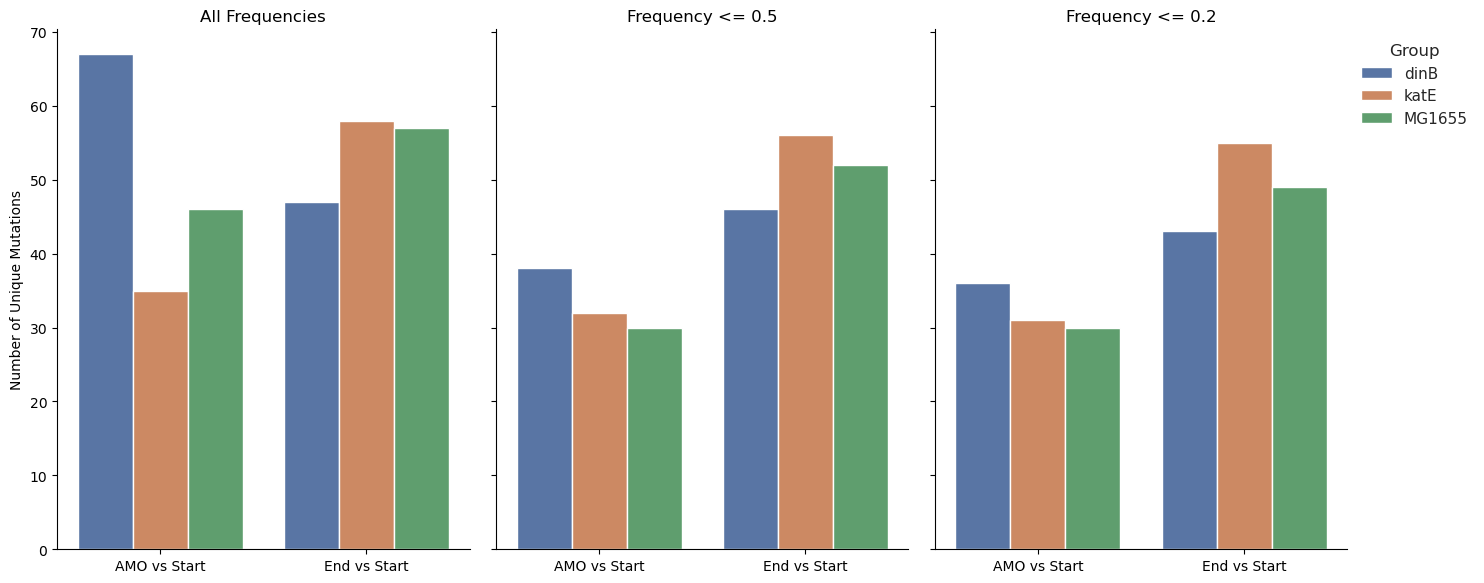

In [57]:
def calculate_comparison_data(df_mut, groups, frequency_filter=None):
    df_tmp = df_mut.copy()
    df_tmp["mutation_position"] = df_tmp["gene_name"] + "_" + df_tmp["gene_position"] 
    comparison_data = []
    for group in groups:
        # Filter the DataFrame for the specific group
        group_df = df_tmp[df_tmp['Sample_cleaned'].str.contains(group)]
        
        if frequency_filter is not None:
            group_df = group_df[group_df.frequency <= frequency_filter]
        
        # Get the unique positions for *AMO, @Start, and @End
        amo_positions = group_df[group_df['Sample_cleaned'].str.contains(f'{group}_AMO')]['mutation_position'].unique()
        start_positions = group_df[group_df['Sample_cleaned'].str.contains(f'{group}_WT@Start')]['mutation_position'].unique()
        end_positions = group_df[group_df['Sample_cleaned'].str.contains(f'{group}_WT@End')]['mutation_position'].unique()
        
        # Calculate the number of unique positions in each category
        num_unique_amo = len(set(amo_positions) - set(start_positions))
        num_unique_start = len(set(end_positions) - set(start_positions))
        
        comparison_data.append({"Group": group, "Comparison": "AMO vs Start", "Count": num_unique_amo})
        comparison_data.append({"Group": group, "Comparison": "End vs Start", "Count": num_unique_start})
    
    return pd.DataFrame(comparison_data)

# Assuming df_mut is your original DataFrame
groups = ['dinB', 'katE', 'MG1655']

# Calculate comparison data for all frequencies
df_comparison_all = calculate_comparison_data(df_mut, groups)

# Calculate comparison data for frequencies <= 0.5
df_comparison_05 = calculate_comparison_data(df_mut, groups, frequency_filter=0.5)

df_comparison_02 = calculate_comparison_data(df_mut, groups, frequency_filter=0.2)

# Create the faceted bar plot using Seaborn
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 6),sharey=True)

sns.set_theme()
sns.barplot(x="Comparison", y="Count", hue="Group", data=df_comparison_all, ax=ax1, legend=False)
ax1.set_title("All Frequencies")
ax1.set_xlabel("")
ax1.set_ylabel("Number of Unique Mutations")

sns.barplot(x="Comparison", y="Count", hue="Group", data=df_comparison_05, ax=ax2, legend=False)
ax2.set_title("Frequency <= 0.5")
ax2.set_xlabel("")



sns.barplot(x="Comparison", y="Count", hue="Group", data=df_comparison_02, ax=ax3)
ax3.set_title("Frequency <= 0.2")
ax3.set_xlabel("")
ax3.legend(title="Group")
sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
sns.despine()
plt.show()

**Fig**: Unique Mutations Across Experimental Groups

This figure shows the number of unique mutations for each experimental group (dinB, katE, MG1655) under different frequency thresholds.

Comparisons:
- AMO vs Start: Mutations in AMO-treated samples absent in start samples
- End vs Start: Mutations in end-point samples absent in start samples

Unique mutations are defined by combining gene name and position.

### Mutations equal or above 0.6 prevalence and has to exist in all replicates

In [58]:
df_mut_filter = []
df_gene_count = []

In [ ]:
def analyze_mutations(df_mut, frequency_threshold):
    # Filter at a prevalence of the given frequency threshold
    df_mut_filter = df_mut[df_mut.frequency >= frequency_threshold]
    
    # Count the occurrence of mutations and see if they occur in all replicates
    # Use both gene_name and title to account for multiple mutations in the same gene
    df_gene_count = df_mut_filter.groupby(["Sample_cleaned", "title", "gene_name"]).size().reset_index(name="count")
    nr_sample = df_mut[["title", "Sample_cleaned"]].drop_duplicates().Sample_cleaned.value_counts().reset_index(name="counts_sample")
    df_gene_count = pd.merge(df_gene_count, nr_sample, on="Sample_cleaned", how="left")
    
    # Group by Sample_cleaned and gene_name, then count unique titles
    df_gene_count = df_gene_count.groupby(["Sample_cleaned", "gene_name"]).agg({
        "title": "nunique",
        "counts_sample": "first"
    }).reset_index()
    df_gene_count.rename(columns={"title": "unique_samples"}, inplace=True)
    
    # If mutations are found in all cases
    df_gene_count = df_gene_count[df_gene_count['unique_samples'] == df_gene_count['counts_sample']]
    
    # Plot venn diagram
    gene_nr = {
        "MG1655_AMO": set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].gene_name.unique()),
        "katE_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].gene_name.unique()),
        "dinB_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].gene_name.unique())
    }
    fig_resources, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    venn(gene_nr, ax=ax1)
    plt.show()
    print(f"Overlapping or unique mutations at frequency id: {frequency_threshold}")
    
    print("\n\n")
    
    # Create sets of unique gene names for each group
    mg_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].gene_name.unique())
    kate_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].gene_name.unique())
    dinb_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].gene_name.unique())
    
    # Find unique genes for each group
    unique_mg_genes = mg_genes - kate_genes - dinb_genes
    unique_kate_genes = kate_genes - mg_genes - dinb_genes
    unique_dinb_genes = dinb_genes - mg_genes - kate_genes
    
    # Find common genes
    common_genes = mg_genes.intersection(kate_genes, dinb_genes)
    
    # Print unique genes for each group
    print("Unique genes in MG1655_AMO:")
    print(", ".join(sorted(unique_mg_genes)))
    print("\nUnique genes in katE_AMO:")
    print(", ".join(sorted(unique_kate_genes)))
    print("\nUnique genes in dinB_AMO:")
    print(", ".join(sorted(unique_dinb_genes)))
    
    # Print common genes
    print("\nCommon genes in all three groups:")
    print(", ".join(sorted(common_genes)))
    
    # Plot table of relevant genes
    relevant_genes = list(set(list(mg_genes) + list(kate_genes) + list(dinb_genes)))
    df_show = df_mut_filter[df_mut_filter.gene_name.isin(relevant_genes)][["frequency", "type", "Strain", "Sample_cleaned", "gene_product", "gene_position", "gene_name", "title", "mutation_category", "new_seq"]]
    df_show = df_mut_filter[df_show.gene_name.isin(relevant_genes)]
    plot_table(df_show, f"MUT_{frequency_threshold}")

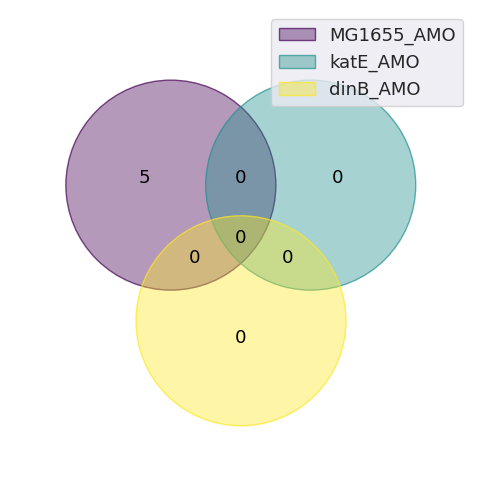

Overlapping or unique mutations at frequency id: 0.6



Unique genes in MG1655_AMO:
ampC/frdD, frdD, gatD/gatB, gltP/yjcO, rtcR/glpG

Unique genes in katE_AMO:


Unique genes in dinB_AMO:


Common genes in all three groups:



In [60]:
analyze_mutations(df_mut, 0.6,)

In [61]:
def analyze_mutations(df_mut, frequency_threshold):
    # Filter at a prevalence of the given frequency threshold
    df_mut_filter = df_mut[df_mut.frequency >= frequency_threshold]
    
    # Count the occurrence of mutations and see if they occur in all replicates
    df_gene_count = df_mut_filter.groupby(["Sample_cleaned", "title"]).gene_name.value_counts().reset_index()
    nr_sample = df_mut[["title", "Sample_cleaned"]].drop_duplicates().Sample_cleaned.value_counts().reset_index(name="counts_sample")
    df_gene_count = pd.merge(df_gene_count, nr_sample, on="Sample_cleaned", how="left")
    
    # If mutations are found in all cases
    df_gene_count = df_gene_count[df_gene_count['count'] == df_gene_count['counts_sample']]
    
    # Plot venn diagram
    gene_nr = {
        "MG1655_AMO": set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].gene_name.unique()),
        "katE_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].gene_name.unique()),
        "dinB_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].gene_name.unique())
    }
    fig_resources, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    venn(gene_nr, ax=ax1)
    plt.show()
    print(f"Overlapping or unique mutations at frequency id: {frequency_threshold}")
    
    print("\n\n")
    
    # Create sets of unique gene names for each group
    mg_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].gene_name.unique())
    kate_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].gene_name.unique())
    dinb_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].gene_name.unique())
    
    # Find unique genes for each group
    unique_mg_genes = mg_genes - kate_genes - dinb_genes
    unique_kate_genes = kate_genes - mg_genes - dinb_genes
    unique_dinb_genes = dinb_genes - mg_genes - kate_genes
    
    # Find common genes
    common_genes = mg_genes.intersection(kate_genes, dinb_genes)
    
    # Print unique genes for each group
    print("Unique genes in MG1655_AMO:")
    print(", ".join(sorted(unique_mg_genes)))
    print("\nUnique genes in katE_AMO:")
    print(", ".join(sorted(unique_kate_genes)))
    print("\nUnique genes in dinB_AMO:")
    print(", ".join(sorted(unique_dinb_genes)))
    
    # Print common genes
    print("\nCommon genes in all three groups:")
    print(", ".join(sorted(common_genes)))
    
    # Plot table of relevant genes
    relevant_genes = list(set(list(mg_genes) + list(kate_genes) + list(dinb_genes)))
    df_show = df_mut_filter[df_mut_filter.gene_name.isin(relevant_genes)][["frequency", "type", "Strain", "Sample_cleaned", "gene_product", "gene_position", "gene_name", "title", "mutation_category", "new_seq"]]
    plot_table(df_show, f"MUT_{frequency_threshold}")

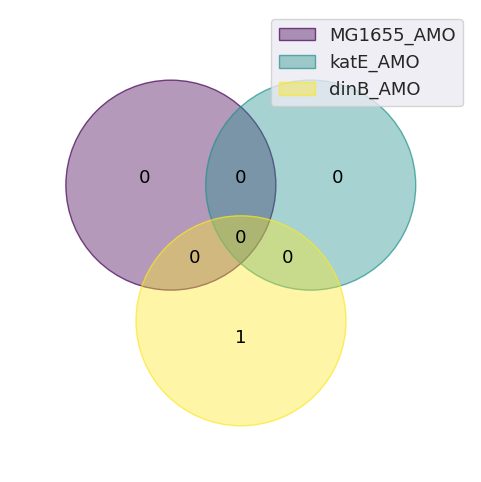

Overlapping or unique mutations at frequency id: 0.6



Unique genes in MG1655_AMO:


Unique genes in katE_AMO:


Unique genes in dinB_AMO:
fre/fadA

Common genes in all three groups:



In [62]:
analyze_mutations(df_mut, 0.6,)

**Table**: This table contains the "significant" genes, but in all samples with no frequency cut of.

### Mutations equal or above 0.3 prevalence and has to exist in all replicates

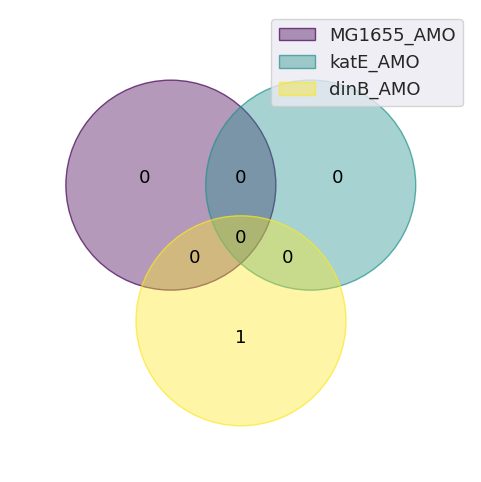

Overlapping or unique mutations at frequency id: 0.3



Unique genes in MG1655_AMO:


Unique genes in katE_AMO:


Unique genes in dinB_AMO:
fre/fadA

Common genes in all three groups:



In [63]:
analyze_mutations(df_mut, 0.3)

**Table** Data regarding mutations above, or equal to a frequency og 0.3 (30%).

### Mutations equal or above 0.6 prevalence and has to exist in at least 2 replicates

In [64]:
def analyze_mutations_2(df_mut, frequency_threshold):
    # Filter at a prevalence of the given frequency threshold
    df_mut_filter = df_mut[df_mut.frequency >= frequency_threshold]
    
    # Count the occurrence of mutations and see if they occur in all replicates
    df_gene_count = df_mut_filter.groupby("Sample_cleaned").gene_name.value_counts().reset_index()
    nr_sample = df_mut[["title", "Sample_cleaned"]].drop_duplicates().Sample_cleaned.value_counts().reset_index(name="counts_sample")
    df_gene_count = pd.merge(df_gene_count, nr_sample, on="Sample_cleaned", how="left")
    
    # If mutations are found in all cases
    df_gene_count = df_gene_count[df_gene_count['count'] >= 2]
    
    # Plot venn diagram
    gene_nr = {
        "MG1655_AMO": set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].gene_name.unique()),
        "katE_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].gene_name.unique()),
        "dinB_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].gene_name.unique())
    }
    fig_resources, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    venn(gene_nr, ax=ax1)
    plt.show()
    print(f"Overlapping or unique mutations at frequency id: {frequency_threshold}")
    
    print("\n\n")
    
    # Create sets of unique gene names for each group
    mg_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].gene_name.unique())
    kate_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].gene_name.unique())
    dinb_genes = set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].gene_name.unique())
    
    # Find unique genes for each group
    unique_mg_genes = mg_genes - kate_genes - dinb_genes
    unique_kate_genes = kate_genes - mg_genes - dinb_genes
    unique_dinb_genes = dinb_genes - mg_genes - kate_genes
    
    # Find common genes
    common_genes = mg_genes.intersection(kate_genes, dinb_genes)
    
    # Print unique genes for each group
    print("Unique genes in MG1655_AMO:")
    print(", ".join(sorted(unique_mg_genes)))
    print("\nUnique genes in katE_AMO:")
    print(", ".join(sorted(unique_kate_genes)))
    print("\nUnique genes in dinB_AMO:")
    print(", ".join(sorted(unique_dinb_genes)))
    
    # Print common genes
    print("\nCommon genes in all three groups:")
    print(", ".join(sorted(common_genes)))
    
    # Plot table of relevant genes
    relevant_genes = list(set(list(mg_genes) + list(kate_genes) + list(dinb_genes)))
    df_show = df_mut_filter[df_mut_filter.gene_name.isin(relevant_genes)][["frequency", "type", "Strain", "Sample_cleaned", "gene_product", "gene_position", "gene_name", "mutation_category", "new_seq", "type"]]
    plot_table(df_show, "MUT")

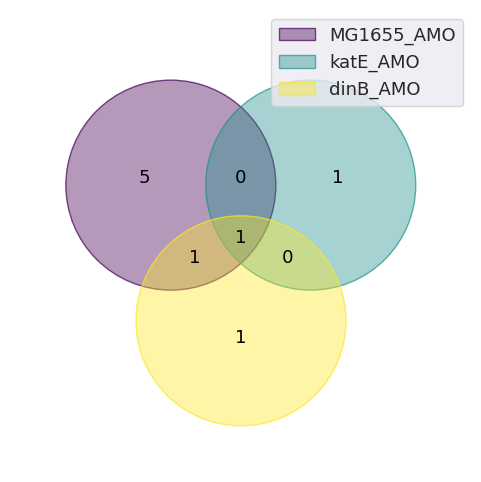

Overlapping or unique mutations at frequency id: 0.6



Unique genes in MG1655_AMO:
gatD/gatB, gltP/yjcO, nanR/dcuD, rtcR/glpG, ydcI/ydcJ

Unique genes in katE_AMO:
rpoD

Unique genes in dinB_AMO:
fre/fadA

Common genes in all three groups:
frdD


In [65]:
analyze_mutations_2(df_mut, 0.6)

### Mutations equal or above 0.3 prevalence and has to exist in at least 2 replicates

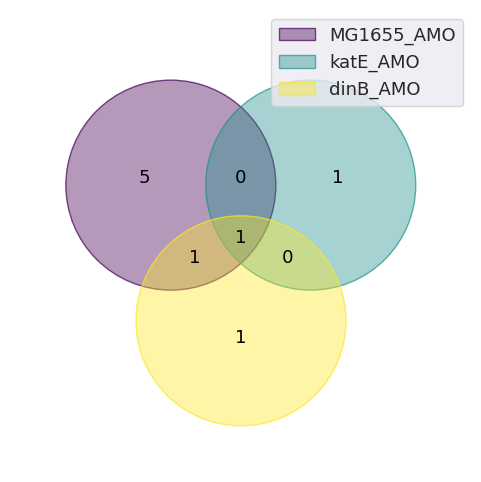

Overlapping or unique mutations at frequency id: 0.3



Unique genes in MG1655_AMO:
gatD/gatB, gltP/yjcO, nanR/dcuD, rtcR/glpG, ydcI/ydcJ

Unique genes in katE_AMO:
rpoD

Unique genes in dinB_AMO:
fre/fadA

Common genes in all three groups:
frdD


In [66]:
analyze_mutations_2(df_mut, 0.3)

## *rpoD*/*prlF* mutation analysis

In [67]:
df_mut[df_mut.gene_name.str.contains("rpoD", case=False, regex=True)][["frequency", "type", "Strain", "Sample_cleaned", "gene_product", "gene_position", "gene_name", "mutation_category", "new_seq", "type", "title"]]

frequency type Strain Sample_cleaned                      gene_product  \
209   1.000000  SNP     BW       dinB_AMO  RNA polymerase sigma factor RpoD   
237   0.065218  SNP     BW       dinB_AMO  RNA polymerase sigma factor RpoD   
317   1.000000  SNP     BW       katE_AMO  RNA polymerase sigma factor RpoD   
369   1.000000  SNP     BW       katE_AMO  RNA polymerase sigma factor RpoD   
320   1.000000  SNP     MG     MG1655_AMO  RNA polymerase sigma factor RpoD   

    gene_position gene_name  mutation_category new_seq type  \
209          1334      rpoD  snp_nonsynonymous       T  SNP   
237          1334      rpoD  snp_nonsynonymous       T  SNP   
317          1334      rpoD  snp_nonsynonymous       T  SNP   
369          1334      rpoD  snp_nonsynonymous       T  SNP   
320          1334      rpoD  snp_nonsynonymous       T  SNP   

                   title  
209   S21_dinB_AMO_First  
237  S22_dinB_AMO_Second  
317  S25_katE_AMO_Second  
369   S27_katE_AMO_First  
320  S9_MG1655_AMO_First

**Table**. This table shows all mentions of *rpoD* mutations in all samples.

In [68]:
df_mut[df_mut.gene_name.str.contains("prlF", case=False, regex=True)][["frequency", "type", "Strain", "Sample_cleaned", "gene_product", "gene_position", "gene_name", "mutation_category", "new_seq", "type", "title"]]

frequency type Strain Sample_cleaned  \
210        1.0  INS     BW       dinB_AMO   
321        1.0  INS     MG     MG1655_AMO   

                                      gene_product        gene_position  \
210  type II toxin-antitoxin system antitoxin PrlF  coding (263/336 nt)   
321                                 antitoxin PrlF  coding (263/336 nt)   

    gene_name mutation_category  new_seq type                title  
210      prlF       small_indel  CATTCAA  INS   S21_dinB_AMO_First  
321      prlF       small_indel  CATTCAA  INS  S9_MG1655_AMO_First

**Table**. This table shows all mentions of *prlF* mutations in all samples.

## Copy number analysis

In [69]:
df_copy_nr = pd.read_csv("data/DNA/pipeline/Copy_number/gene_cp_nr.csv")
df_copy_nr = df_copy_nr[df_copy_nr.Type == "CDS"]

gene_data = []
gtf = 'data/DNA/genomic.gtf'
with open(gtf, 'r') as f:
    for line in f:
        if 'GeneID' in line:
            # Extract the gene_id and gene_name information from the line
            gene_id = line.split('gene_id "')[-1].split('";')[0]
            gene_name = line.split('; gene "')[-1].split('";')[0]
            # Add the extracted data to the gene_data list
            gene_data.append((gene_id, gene_name))
            
# Convert the gene_data list to a pandas dataframe and set the gene_id as the index
gene_dict = pd.DataFrame(gene_data, columns=["Locus", "Gene_name"])
df_copy_nr = pd.merge(df_copy_nr, gene_dict, on ="Locus", how = "left")
df_copy_nr.head()

Type  Locus  Strand  Left  Right  Length   CN_boot  Lowerbound  Upperbound  \
0  CDS  b0001       1   190    255      66  1.219336    1.204350    1.234322   
1  CDS  b0002       1   337   2799    2463  0.959120    0.884126    1.035313   
2  CDS  b0003       1  2801   3733     933  0.966750    0.933507    1.002178   
3  CDS  b0004       1  3734   5020    1287  1.022374    0.975659    1.070062   
4  CDS  b0005       1  5234   5530     297  1.061980    0.959120    1.164841   

                            Sample Gene_name  
0  S11_MG1655_WT@Start_Second.hits      thrL  
1  S11_MG1655_WT@Start_Second.hits      thrA  
2  S11_MG1655_WT@Start_Second.hits      thrB  
3  S11_MG1655_WT@Start_Second.hits      thrC  
4  S11_MG1655_WT@Start_Second.hits      yaaX

In [70]:
# Define the conditions
conditions = [
    (df_copy_nr['CN_boot'] > 0) & (df_copy_nr['CN_boot'] <= 1.5),
    (df_copy_nr['CN_boot'] > 1.5) & (df_copy_nr['CN_boot'] <= 2.0),
    (df_copy_nr['CN_boot'] > 2.0)
]

# Define the choices corresponding to the conditions
choices = ['0-1.5', '>1.5-2', '>2']

# Apply np.select to assign values based on the conditions
df_copy_nr['CN'] = np.select(conditions, choices, default='0')
df_copy_nr['Sample_cleaned'] = df_copy_nr['Sample'].str.replace(r'^S\d+_', '', regex=True).str.replace(".hits", "")
df_copy_nr['Sample_cleaned'] = df_copy_nr['Sample_cleaned'].str.replace('_Second', '', regex=False)
df_copy_nr['Sample_cleaned'] = df_copy_nr['Sample_cleaned'].str.replace('_First', '', regex=False)

df_copy_nr['Type'] = np.where(df_copy_nr['Sample_cleaned'].str.contains('@Start'), 'WT_Start',
                     np.where(df_copy_nr['Sample_cleaned'].str.contains('AMO'), 'AMO',
                     np.where(df_copy_nr['Sample_cleaned'].str.contains('@End'), 'WT_End', '')))

df_copy_nr["Title"] = df_copy_nr.Sample.str.split(".hits").str[0]
df_copy_nr = df_copy_nr[~df_copy_nr.Title.isin(['S11_MG1655_WT@Start_Second', 'S12_MG1655_WT@End_Second','S1_MG1655_WT@Start_First', 'S2_MG1655_WT@End_First', 'S3_MG1655_AMO_First'])]
df_copy_nr.head()

Type  Locus  Strand  Left  Right  Length   CN_boot  Lowerbound  \
8674  WT_Start  b0001       1   190    255      66  1.186176    1.173182   
8675  WT_Start  b0002       1   337   2799    2463  0.942704    0.868444   
8676  WT_Start  b0003       1  2801   3733     933  0.970474    0.921811   
8677  WT_Start  b0004       1  3734   5020    1287  1.032899    0.972960   
8678  WT_Start  b0005       1  5234   5530     297  1.059948    0.966205   

      Upperbound                         Sample Gene_name     CN  \
8674    1.199170  S13_dinB_WT@Start_Second.hits      thrL  0-1.5   
8675    1.012215  S13_dinB_WT@Start_Second.hits      thrA  0-1.5   
8676    1.024687  S13_dinB_WT@Start_Second.hits      thrB  0-1.5   
8677    1.090716  S13_dinB_WT@Start_Second.hits      thrC  0-1.5   
8678    1.188961  S13_dinB_WT@Start_Second.hits      yaaX  0-1.5   

     Sample_cleaned                     Title  
8674  dinB_WT@Start  S13_dinB_WT@Start_Second  
8675  dinB_WT@Start  S13_dinB_WT@Start_Second  
8676  dinB_WT@Start  S13_dinB_WT@Start_Second  
8677  dinB_WT@Start  S13_dinB_WT@Start_Second  
8678  dinB_WT@Start  S13_dinB_WT@Start_Second

In [71]:
df_copy_nr[["Sample", "Sample_cleaned"]].drop_duplicates().Sample_cleaned.value_counts()


Sample_cleaned
dinB_WT@End        3
katE_AMO           3
katE_WT@End        3
dinB_AMO           3
MG1655_WT@End      3
MG1655_AMO         3
dinB_WT@Start      2
MG1655_WT@Start    2
katE_WT@Start      2
Name: count, dtype: int64

**Table**: Nr of genomes per treatment.

<Axes: >

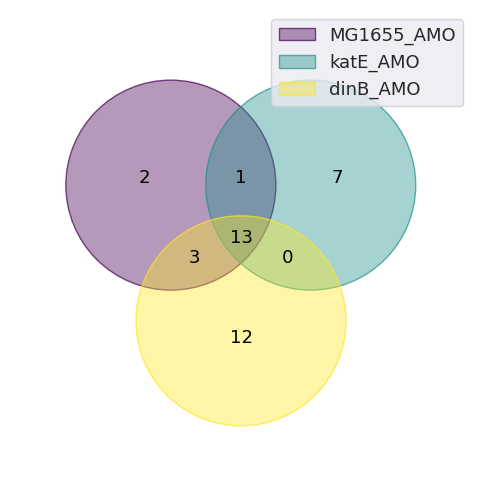

In [72]:
df_copy_nr_2 = df_copy_nr[df_copy_nr.CN_boot >= 1.5]
df_gene_count = df_copy_nr_2.groupby("Sample_cleaned").Gene_name.value_counts().reset_index()
nr_sample = df_copy_nr[["Sample", "Sample_cleaned"]].drop_duplicates().Sample_cleaned.value_counts().reset_index(name="counts_sample")
df_gene_count = pd.merge(df_gene_count, nr_sample, on ="Sample_cleaned", how = "left")
df_gene_count = df_gene_count[df_gene_count['count'] == df_gene_count['counts_sample']]

gene_nr = {
    "MG1655_AMO": set(df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].Gene_name.unique()),
    "katE_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].Gene_name.unique()),
    "dinB_AMO":   set(df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].Gene_name.unique())
}
fig_resources, (ax1)= plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

venn(gene_nr, ax=ax1)

**Fig**: Nr of unique gene with equal or above 1.5 copy numbers for each type. **If** on observation for a gene was above 1.5.

In [73]:
list_mg_nr = df_gene_count[df_gene_count.Sample_cleaned == "MG1655_AMO"].Gene_name.unique()
df_mg_nr = df_copy_nr[(df_copy_nr.Gene_name.isin(list_mg_nr)) & (df_copy_nr.Sample_cleaned.isin(["MG1655_WT@Start", "MG1655_AMO","MG1655_WT@End"]))]

list_kate_nr = df_gene_count[df_gene_count.Sample_cleaned == "katE_AMO"].Gene_name.unique()
df_kate_nr = df_copy_nr[(df_copy_nr.Gene_name.isin(list_kate_nr)) & (df_copy_nr.Sample_cleaned.isin(["katE_WT@Start", "katE_AMO","katE_WT@End"]))]

list_dinb_nr = df_gene_count[df_gene_count.Sample_cleaned == "dinB_AMO"].Gene_name.unique()
df_dinb_nr = df_copy_nr[(df_copy_nr.Gene_name.isin(list_dinb_nr)) & (df_copy_nr.Sample_cleaned.isin(["dinB_WT@Start", "dinB_AMO","dinB_WT@End"]))]

df_nr_comb = pd.concat([df_mg_nr, df_kate_nr, df_dinb_nr])

In [74]:
# Create sets of unique gene names for each group
mg_genes = set(df_mg_nr.Gene_name.unique())
kate_genes = set(df_kate_nr.Gene_name.unique())
dinb_genes = set(df_dinb_nr.Gene_name.unique())

# Find unique genes for each group
unique_mg_genes = mg_genes - kate_genes - dinb_genes
unique_kate_genes = kate_genes - mg_genes - dinb_genes
unique_dinb_genes = dinb_genes - mg_genes - kate_genes

# Find common genes
common_genes = mg_genes.intersection(kate_genes, dinb_genes)

# Print unique genes for each group
print("Unique genes in MG1655_AMO:")
print(", ".join(sorted(unique_mg_genes)))
print("\nUnique genes in katE_AMO:")
print(", ".join(sorted(unique_kate_genes)))
print("\nUnique genes in dinB_AMO:")
print(", ".join(sorted(unique_dinb_genes)))

# Print common genes
print("\nCommon genes in all three groups:")
print(", ".join(sorted(common_genes)))

Unique genes in MG1655_AMO:
mscM, yjeO

Unique genes in katE_AMO:
frsA, insA6, insB1, insB5, insB6, insB9, nhaR

Unique genes in dinB_AMO:
aspA, cutA, dcuA, dsbD, fxsA, groL, groS, insG, psd, yjdC, yjeH, yjeI

Common genes in all three groups:
ampC, blc, ecnA, ecnB, efp, epmA, epmB, frdA, frdB, frdC, frdD, gdx, yjeJ


**Table** Unlike and common genes with increased copy nr per treatment. **If** on observation for a gene was above 1.5.

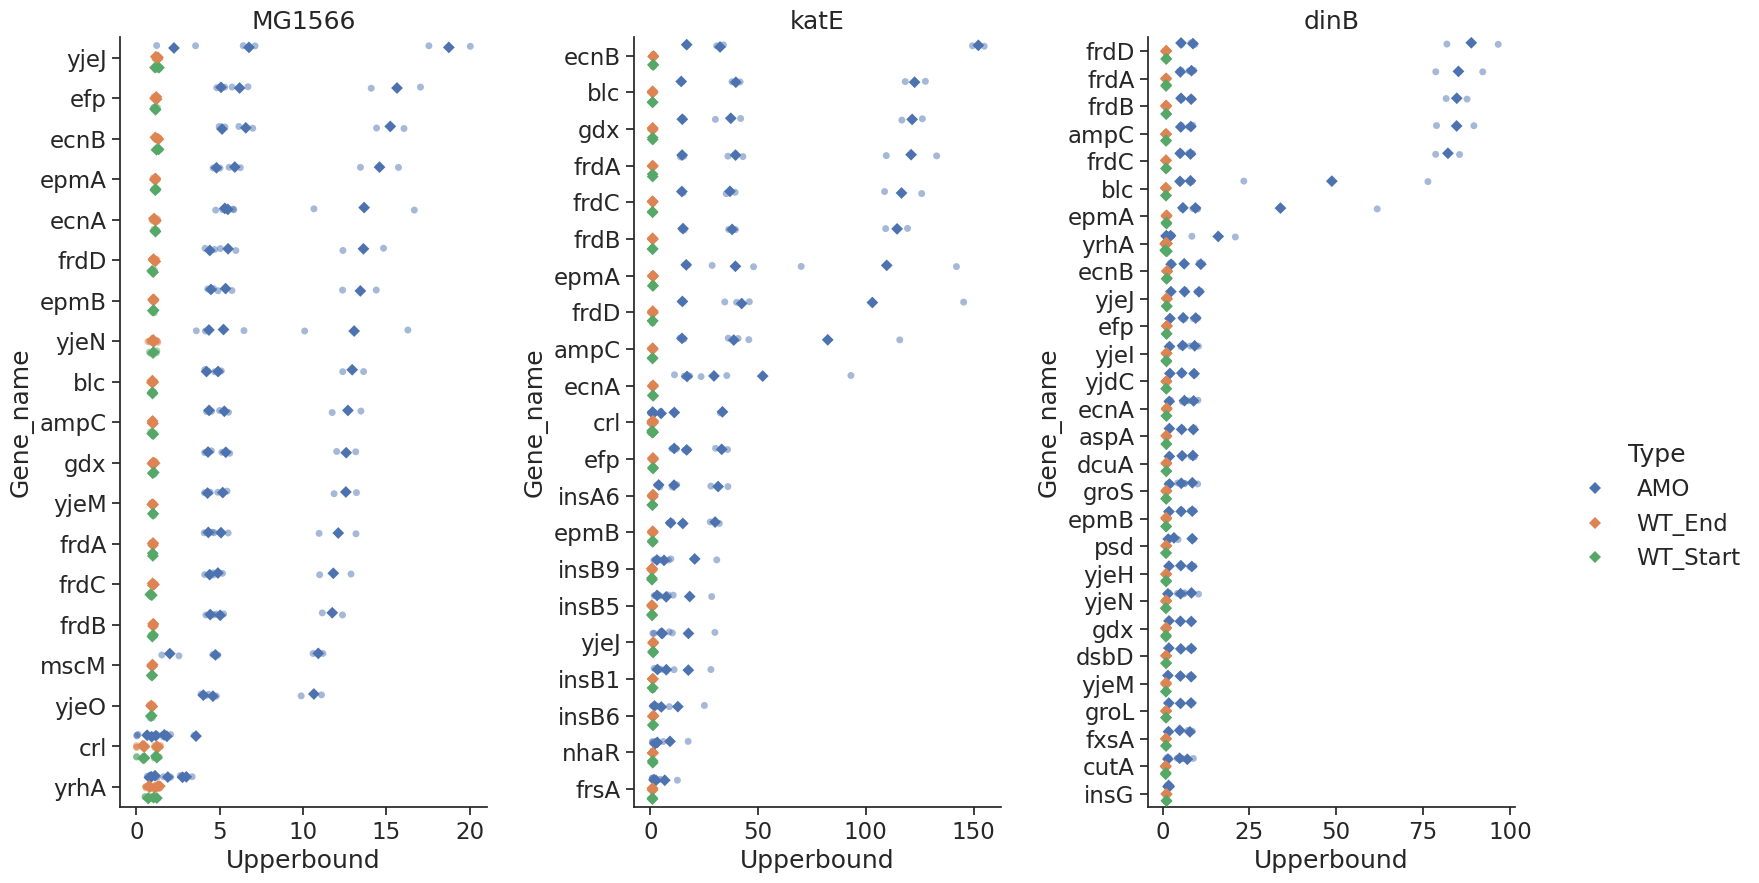

In [75]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.axes_style()
sns.set_palette("muted")

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))

# List of DataFrames and corresponding axes
df_ax_pairs = [(df_mg_nr, ax1, "MG1566"), (df_kate_nr, ax2, "katE"), (df_dinb_nr, ax3, "dinB")]

# Loop over the DataFrame-axis pairs
for i, (df, ax, type_) in enumerate(df_ax_pairs, start=1):
    legend=False
    if type_ == "dinB":
       legend=True 
       
    df = df.sort_values(by="CN_boot", ascending=False)
    
    sns.stripplot(data=df, x="Upperbound", y="Gene_name", hue="Type", dodge=True, alpha=.5, legend=False, ax=ax, palette="deep")
    sns.stripplot(data=df, x="Lowerbound", y="Gene_name", hue="Type", dodge=True, alpha=.5, legend=False, ax=ax, palette="deep")
    sns.stripplot(data=df, x="CN_boot", y="Gene_name", hue="Type", dodge=True, alpha=1, legend=legend, ax=ax, palette="deep",marker="D",s=6)
    sns.despine(ax=ax)
    
    # Add subplot label
    ax.set_title(f"{type_}", loc="center")

sns.move_legend(ax3, "upper left", bbox_to_anchor=(1.1, 0.5), frameon=False)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

**Fig**: Genes with a bootstrapped abundance above 1.5. The rhomboid shaped represent the bootstrapped values.  The transparent circles represents the corresponding lower and upper bounds.**If** on observation for a gene was above 1.5.

In [76]:
df_mg_median = df_mg_nr[df_mg_nr.Type =="AMO"].groupby(["Gene_name"]).CN_boot.median().reset_index()
df_mg_median = df_mg_median.rename(columns={"Gene_name":"gene_name",})
df_tmp = df_tr_2[(df_tr_2.gene_name.isin(mg_genes)) & (df_tr_2.First == "MG1655_AMO_NT")][["logFC","logCPM", "gene_name", "cleaned_contrast", "label", "PValue"]].sort_values(by="label")
pd.merge(df_tmp, df_mg_median, on ="gene_name")

logFC    logCPM gene_name             cleaned_contrast  \
0   -1.211766  4.398379       crl  MG1655_AMO_NT_MG1655_POS_NT   
1    1.113786  4.359715      yjeO  MG1655_AMO_NT_MG1655_POS_NT   
2    2.671856  2.916563      yjeN  MG1655_AMO_NT_MG1655_POS_NT   
3    1.616396  2.588961      yjeM  MG1655_AMO_NT_MG1655_POS_NT   
4    2.756809  8.605412      frdA  MG1655_AMO_NT_MG1655_POS_NT   
5    2.610537  6.836700      frdB  MG1655_AMO_NT_MG1655_POS_NT   
6    2.319797  5.954308      frdD  MG1655_AMO_NT_MG1655_POS_NT   
7    3.320275  5.818407      frdC  MG1655_AMO_NT_MG1655_POS_NT   
8    0.541321  0.878897      yjeJ  MG1655_AMO_NT_MG1655_POS_NT   
9    0.480274 -2.303625      yrhA  MG1655_AMO_NT_MG1655_POS_NT   
10  -0.633384  5.503140      ecnB  MG1655_AMO_NT_MG1655_POS_NT   
11   3.744375  4.750644       blc  MG1655_AMO_NT_MG1655_POS_NT   
12   3.305888  3.245878      ecnA  MG1655_AMO_NT_MG1655_POS_NT   
13   2.924785  4.581465       gdx  MG1655_AMO_NT_MG1655_POS_NT   
14   1.356619  6.567903       efp  MG1655_AMO_NT_MG1655_POS_NT   
15   2.163898  4.184438      epmA  MG1655_AMO_NT_MG1655_POS_NT   
16   2.704463  5.019371      epmB  MG1655_AMO_NT_MG1655_POS_NT   
17   1.325531  2.116212      mscM  MG1655_AMO_NT_MG1655_POS_NT   
18  10.348602  7.887953      ampC  MG1655_AMO_NT_MG1655_POS_NT   

              label        PValue   CN_boot  
0              Down  9.924381e-04  1.423650  
1   Non-significant  2.075725e-01  4.595678  
2   Non-significant  2.727944e-02  5.229720  
3   Non-significant  1.602588e-02  5.183038  
4   Non-significant  3.162453e-03  5.078245  
5   Non-significant  9.144678e-03  5.032491  
6   Non-significant  3.694156e-03  5.505139  
7   Non-significant  3.048190e-03  4.895607  
8   Non-significant  5.914994e-01  6.757098  
9   Non-significant  7.552997e-01  1.502426  
10  Non-significant  4.349037e-01  6.569401  
11               Up  3.740484e-08  4.902978  
12               Up  2.015297e-07  5.489013  
13               Up  6.961869e-07  5.366462  
14               Up  9.707063e-04  6.195757  
15               Up  1.503675e-03  5.907095  
16               Up  2.114581e-06  5.354148  
17               Up  1.574899e-03  4.744409  
18               Up  3.867709e-14  5.279386

**Table**: MG1655 POS_NT vs  AMO_NT transcriptome data in relation to mutation data. `logFC	logCPM	gene_name	cleaned_contrast	label	PValue` are columns form the transcriptome data. `cleaned_contrast`is which groups were compared. `label` if it was significant, and if so in what direction. `CN_boot` is the median bootstrapped gene copy number from the gene copy number analysis. 

In [77]:
df_mg_median = df_kate_nr[df_kate_nr.Type =="AMO"].groupby(["Gene_name"]).CN_boot.median().reset_index()
df_mg_median = df_mg_median.rename(columns={"Gene_name":"gene_name",})
df_tmp = df_tr_2[(df_tr_2.gene_name.isin(kate_genes)) & (df_tr_2.First == "katE_AMO_NT")][["logFC","logCPM", "gene_name", "cleaned_contrast", "label", "PValue"]].sort_values(by="label")
pd.merge(df_tmp, df_mg_median, on ="gene_name")

logFC    logCPM gene_name         cleaned_contrast            label  \
0  -0.725077  1.887033      nhaR  katE_AMO_NT_katE_POS_NT  Non-significant   
1   0.624840 -0.158214     insB1  katE_AMO_NT_katE_POS_NT  Non-significant   
2   0.979014  2.492847      frsA  katE_AMO_NT_katE_POS_NT  Non-significant   
3  -0.383199  4.398379       crl  katE_AMO_NT_katE_POS_NT  Non-significant   
4  -0.106110 -0.339247     insB5  katE_AMO_NT_katE_POS_NT  Non-significant   
5  -2.183863  0.878897      yjeJ  katE_AMO_NT_katE_POS_NT  Non-significant   
6   4.164090  4.184438      epmA  katE_AMO_NT_katE_POS_NT               Up   
7   4.956966  8.605412      frdA  katE_AMO_NT_katE_POS_NT               Up   
8   4.782048  6.836700      frdB  katE_AMO_NT_katE_POS_NT               Up   
9   5.776449  5.818407      frdC  katE_AMO_NT_katE_POS_NT               Up   
10  5.541053  5.954308      frdD  katE_AMO_NT_katE_POS_NT               Up   
11  4.244946  4.581465       gdx  katE_AMO_NT_katE_POS_NT               Up   
12  4.271741  4.750644       blc  katE_AMO_NT_katE_POS_NT               Up   
13  5.108957  3.245878      ecnA  katE_AMO_NT_katE_POS_NT               Up   
14  4.537454  6.567903       efp  katE_AMO_NT_katE_POS_NT               Up   
15  4.809940  5.019371      epmB  katE_AMO_NT_katE_POS_NT               Up   
16  7.490732  7.887953      ampC  katE_AMO_NT_katE_POS_NT               Up   
17  3.679285  5.503140      ecnB  katE_AMO_NT_katE_POS_NT               Up   

          PValue    CN_boot  
0   4.432248e-02   3.173228  
1   3.448377e-01   7.368879  
2   6.491574e-03   2.539491  
3   2.609105e-01   3.066746  
4   8.650409e-01   7.289262  
5   2.936355e-02   5.506541  
6   1.646502e-07  39.447724  
7   8.642961e-06  39.489302  
8   3.157359e-05  37.915357  
9   6.967423e-06  36.904467  
10  1.633642e-07  42.343729  
11  5.166238e-10  37.298570  
12  1.839613e-09  39.632318  
13  2.703701e-13  29.467553  
14  1.398550e-12  16.809085  
15  2.929010e-11  15.004055  
16  8.168579e-12  38.675937  
17  1.681709e-04  32.307694

**Table**: katE POS_NT vs  AMO_NT transcriptome data in relation to mutation data. `logFC	logCPM	gene_name	cleaned_contrast	label	PValue` are columns form the transcriptome data. `cleaned_contrast`is which groups were compared. `label` if it was significant, and if so in what direction. `CN_boot` is the median bootstrapped gene copy number from the gene copy number analysis. 

In [78]:
df_mg_median = df_dinb_nr[df_dinb_nr.Type =="AMO"].groupby(["Gene_name"]).CN_boot.median().reset_index()
df_mg_median = df_mg_median.rename(columns={"Gene_name":"gene_name",})
df_tmp = df_tr_2[(df_tr_2.gene_name.isin(dinb_genes)) & (df_tr_2.First == "dinB_AMO_NT")][["logFC","logCPM", "gene_name", "cleaned_contrast", "label", "PValue"]].sort_values(by="label")
pd.merge(df_tmp, df_mg_median, on ="gene_name")

logFC    logCPM gene_name         cleaned_contrast            label  \
0  -1.863649 -0.081091      insG  dinB_AMO_NT_dinB_POS_NT             Down   
1  -1.732018 -2.303625      yrhA  dinB_AMO_NT_dinB_POS_NT  Non-significant   
2   1.109782  4.672121      dcuA  dinB_AMO_NT_dinB_POS_NT  Non-significant   
3   1.362901  5.503140      ecnB  dinB_AMO_NT_dinB_POS_NT  Non-significant   
4   0.787183  1.772349      dsbD  dinB_AMO_NT_dinB_POS_NT  Non-significant   
5  -1.211277  2.695460      yjdC  dinB_AMO_NT_dinB_POS_NT  Non-significant   
6   0.278455  0.250952      cutA  dinB_AMO_NT_dinB_POS_NT  Non-significant   
7   1.406479  2.694027       psd  dinB_AMO_NT_dinB_POS_NT               Up   
8   6.801704  2.916563      yjeN  dinB_AMO_NT_dinB_POS_NT               Up   
9   3.191119  2.588961      yjeM  dinB_AMO_NT_dinB_POS_NT               Up   
10  2.137803  4.184438      epmA  dinB_AMO_NT_dinB_POS_NT               Up   
11  5.488202  8.605412      frdA  dinB_AMO_NT_dinB_POS_NT               Up   
12  6.034449  6.836700      frdB  dinB_AMO_NT_dinB_POS_NT               Up   
13  5.280897  5.818407      frdC  dinB_AMO_NT_dinB_POS_NT               Up   
14  4.494265  5.954308      frdD  dinB_AMO_NT_dinB_POS_NT               Up   
15  7.026935  7.887953      ampC  dinB_AMO_NT_dinB_POS_NT               Up   
16  3.255701  4.750644       blc  dinB_AMO_NT_dinB_POS_NT               Up   
17  3.585824  3.245878      ecnA  dinB_AMO_NT_dinB_POS_NT               Up   
18  4.164768  5.019371      epmB  dinB_AMO_NT_dinB_POS_NT               Up   
19  2.713493  0.878897      yjeJ  dinB_AMO_NT_dinB_POS_NT               Up   
20  3.982678  3.153073      yjeI  dinB_AMO_NT_dinB_POS_NT               Up   
21  5.499978  8.502987      groL  dinB_AMO_NT_dinB_POS_NT               Up   
22  4.443081  5.623207      groS  dinB_AMO_NT_dinB_POS_NT               Up   
23  3.562609  2.926068      yjeH  dinB_AMO_NT_dinB_POS_NT               Up   
24  4.786811  4.868763      fxsA  dinB_AMO_NT_dinB_POS_NT               Up   
25  4.624865  8.808948      aspA  dinB_AMO_NT_dinB_POS_NT               Up   
26  4.201571  4.581465       gdx  dinB_AMO_NT_dinB_POS_NT               Up   
27  4.200032  6.567903       efp  dinB_AMO_NT_dinB_POS_NT               Up   

          PValue   CN_boot  
0   1.684729e-03  1.753466  
1   2.556628e-01  1.521084  
2   3.426926e-02  5.623574  
3   9.233249e-02  6.215216  
4   1.665634e-02  5.246780  
5   3.271359e-03  5.524449  
6   5.701794e-01  4.902588  
7   1.625034e-04  3.280493  
8   2.839385e-07  5.165904  
9   1.936180e-05  5.121771  
10  9.374788e-04  9.455918  
11  2.617072e-06  8.325672  
12  2.784479e-06  8.226299  
13  1.299617e-05  8.036275  
14  2.276009e-06  8.734798  
15  4.099845e-11  8.134674  
16  2.033927e-07  8.035232  
17  1.236708e-09  6.288360  
18  5.048077e-10  5.345402  
19  2.211267e-04  6.318803  
20  7.642477e-09  5.762518  
21  7.082891e-09  5.161904  
22  1.623782e-07  5.377032  
23  6.426300e-08  5.248819  
24  5.764321e-11  4.928287  
25  1.403081e-06  5.482546  
26  6.861777e-10  5.121030  
27  7.732346e-12  5.927161

**Table**: dinB POS_NT vs  AMO_NT transcriptome data in relation to mutation data. `logFC	logCPM	gene_name	cleaned_contrast	label	PValue` are columns form the transcriptome data. `cleaned_contrast`is which groups were compared. `label` if it was significant, and if so in what direction. `CN_boot` is the median bootstrapped gene copy number from the gene copy number analysis. 

# Python Packages

In [79]:
for package in pkg_resources.working_set:
    print(f"{package.key} - Version: {package.version}")

babel - Version: 2.14.0
markupsafe - Version: 2.1.5
pyqt5 - Version: 5.15.9
pyqt5-sip - Version: 12.12.2
pysocks - Version: 1.7.1
pyyaml - Version: 6.0.2
send2trash - Version: 1.8.3
adjusttext - Version: 1.2.0
anyio - Version: 4.4.0
archspec - Version: 0.2.3
argon2-cffi - Version: 23.1.0
argon2-cffi-bindings - Version: 21.2.0
arrow - Version: 1.3.0
asttokens - Version: 2.4.1
async-lru - Version: 2.0.4
attrs - Version: 24.2.0
beautifulsoup4 - Version: 4.12.3
bleach - Version: 6.1.0
boltons - Version: 23.0.0
brotlipy - Version: 0.7.0
cached-property - Version: 1.5.2
certifi - Version: 2024.7.4
cffi - Version: 1.15.1
charset-normalizer - Version: 2.0.4
cloudpickle - Version: 3.0.0
comm - Version: 0.2.2
conda - Version: 24.7.1
conda-content-trust - Version: 0.1.3
conda-libmamba-solver - Version: 24.7.0
conda-package-handling - Version: 2.3.0
conda-package-streaming - Version: 0.10.0
contourpy - Version: 1.2.1
cryptography - Version: 39.0.1
cycler - Version: 0.12.1
debugpy - Version: 1.8.5


# R Packages

In [80]:
%%R
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
[1] C

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] stringi_1.8.4          ggpubr_0.6.0           ggrepel_0.9.5         
 [4] ggtext_0.1.2           glue_1.7.0             DT_0.33               
 [7] viridis_0.6.5          viridisLite_0.4.2      GO.db_3.18.0          
[10] org.EcK12.eg.db_3.18.0 AnnotationDbi_1.64.1   IRanges_2.36.0        
[13] S4Vectors_0.40.2       Biobase_2.62.0         BiocGenerics_0.48.1   
[16] lubridate_1.9.3        forcats_1.0.0          stringr_1.5.1         
[19] dplyr_1.1.4            purrr_1.0.2            readr_2.1.5           
[22] tidyr_1.3.1            tibble_3.2.1         

## Manuscript plots

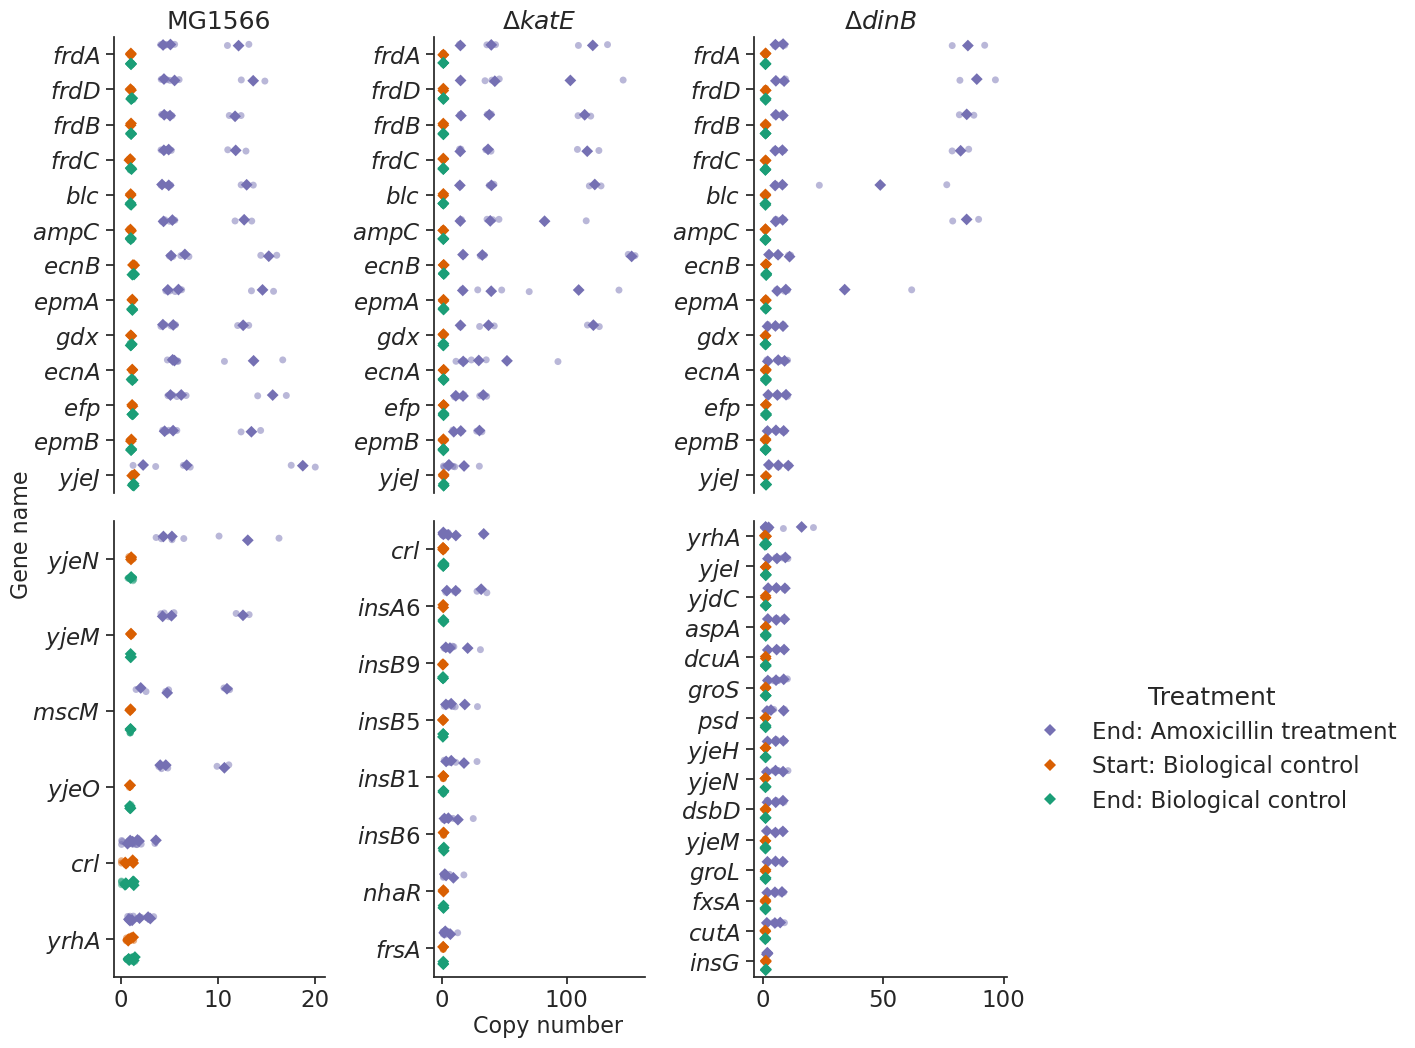

In [82]:
# Set the style and context
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Use the muted color palette
sns.set_palette("muted")

# Define a consistent color palette for treatments using the muted palette
color_palette = {"End: Biological control": "#1b9e77", "Start: Biological control": "#d95f02", "End: Amoxicillin treatment": "#7570b3"}

# Define a consistent color palette for treatments using the muted palette with desired order
color_palette = OrderedDict([
    ("End: Amoxicillin treatment", "#7570b3"),
    ("Start: Biological control", "#d95f02"),
    ("End: Biological control", "#1b9e77")
])


# Create a figure with six subplots (3 on top, 3 below)
fig = plt.figure(figsize=(17, 12))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1.2])

axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# List of DataFrames and corresponding axes
df_ax_pairs = [
    (df_mg_nr, axes[0][0], axes[1][0], "MG1566"),
    (df_kate_nr, axes[0][1], axes[1][1], "$\Delta$$\it{katE}$"),
    (df_dinb_nr, axes[0][2], axes[1][2], "$\Delta$$\it{dinB}$")
]

# Function to plot genes
def plot_genes(df, ax, genes=None, title=None, legend=False, is_top=False, consistent_order=None):
    if genes:
        df = df[df['Gene_name'].isin(genes)]
    
    if consistent_order and is_top:
        df['Gene_order'] = df['Gene_name'].map({gene: i for i, gene in enumerate(consistent_order)})
        df = df.sort_values('Gene_order')
    else:
        df = df.sort_values(by="CN_boot", ascending=False)
    
    # Update the 'Type' column with new labels
    df['Treatment'] = df['Type'].replace({
        'WT_End': 'End: Biological control',
        'WT_Start': 'Start: Biological control',
        'AMO': 'End: Amoxicillin treatment'
    })
    
    df['Gene_name_italic'] = df['Gene_name'].apply(lambda x: '$\it{' + x + '}$')
    treatment_order = list(color_palette.keys())
    sns.stripplot(data=df, x="Upperbound", y="Gene_name_italic", hue="Treatment", dodge=True, alpha=.5, legend=False, hue_order=treatment_order, ax=ax, palette=color_palette)
    sns.stripplot(data=df, x="Lowerbound", y="Gene_name_italic", hue="Treatment", dodge=True, alpha=.5, legend=False, hue_order=treatment_order, ax=ax, palette=color_palette)
    sns.stripplot(data=df, x="CN_boot", y="Gene_name_italic", hue="Treatment", dodge=True, alpha=1, legend=legend, hue_order=treatment_order, ax=ax, palette=color_palette, marker="D", s=6)
    
    # Remove bottom spine only for top subplots
    if is_top:
        sns.despine(ax=ax, bottom=True)
    else:
        sns.despine(ax=ax, bottom=False)
    
    # Remove x-axis label
    ax.set_xlabel('')
    
    if is_top:
        ax.set_xticklabels([])
        ax.tick_params(axis='x', which='both', length=0)
    else:
        ax.tick_params(axis='x', which='both', length=5)
    
    # Remove y-axis labels for all subplots
    ax.set_ylabel('')
    
    if title:
        ax.set_title(title, loc="center")

# Determine consistent order for top genes
all_top_data = pd.concat([df[df['Gene_name'].isin(common_genes)] for df, _, _, _ in df_ax_pairs])
consistent_order = all_top_data.groupby('Gene_name')['CN_boot'].mean().sort_values(ascending=False).index.tolist()

# Plot genes in all subplots
for df, ax_top, ax_bottom, title in df_ax_pairs:
    # Plot top genes
    plot_genes(df, ax_top, genes=common_genes, title=f"{title}", is_top=True, consistent_order=consistent_order)
    
    # Plot remaining genes
    remaining_genes = [gene for gene in df['Gene_name'].unique() if gene not in common_genes]
    legend = (title == "$\Delta$$\it{dinB}$")
    plot_genes(df, ax_bottom, genes=remaining_genes, title="", legend=legend, is_top=False)
    
    # Synchronize x-axis limits
    x_min = min(ax_top.get_xlim()[0], ax_bottom.get_xlim()[0])
    x_max = max(ax_top.get_xlim()[1], ax_bottom.get_xlim()[1])
    ax_top.set_xlim(x_min, x_max)
    ax_bottom.set_xlim(x_min, x_max)

# Add common x-axis label centered to the middle subplot
fig.text(0.40, 0.09, 'Copy number', ha='center', va='center', fontsize=16)

# Add common y-axis label
fig.text(0.09, 0.5, 'Gene name', ha='center', va='center', rotation='vertical', fontsize=16)

# Adjust the legend
legend = axes[1][2].get_legend()
if legend:
    legend.set_title("Treatment")
    handles = legend.legendHandles
    labels = [t.get_text() for t in legend.get_texts()]
    ax = axes[1][2]
    ax.legend(handles, labels, title="Treatment", loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust the spacing between subplots
plt.tight_layout(rect=[0.08, 0.08, 0.92, 0.96])

plt.savefig('documentation/RNA/scientific_questions/plots/cp_nr.png', dpi=300, bbox_inches='tight')

plt.show()

**Figure 2**

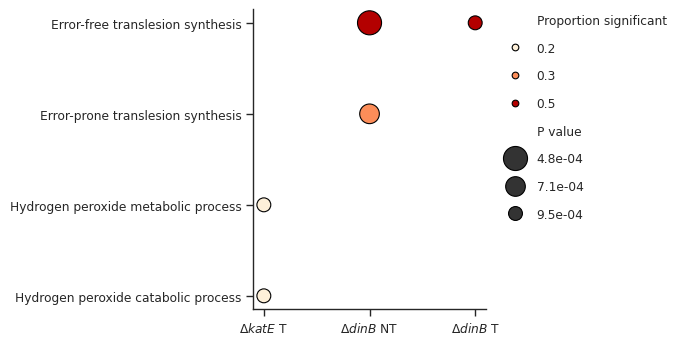

In [83]:
sns.set_context("paper")

# Create a copy of the DataFrame to avoid modifying the original
df_plot = df_go[(df_go.P <= 0.001) & (df_go.Ont == "BP")].copy()

# Create the color palette
color_palette = ['#fef0d9', '#fc8d59', '#b30000']

df_plot["First"] = df_plot["First"].str.replace("_POS_", " ").str.replace("katE", "$\Delta$$\it{katE}$").str.replace("dinB", "$\Delta$$\it{dinB}$")

# Convert P-values to exponential notation
df_plot['P value'] = df_plot['P'].apply(lambda x: f'{x:.1e}')
df_plot['Term'] = df_plot['Term'].apply(lambda x: x.capitalize())

# Round Proportion_significant to 2 decimal places
df_plot['Proportion_significant'] = df_plot['Proportion_significant'].round(1)
df_plot['Proportion significant'] = df_plot['Proportion_significant'].copy()

x_order = ["$\Delta$$\it{katE}$ T", "$\Delta$$\it{dinB}$ NT", "$\Delta$$\it{dinB}$ T"]  # Adjust this list as needed
df_plot['First'] = pd.Categorical(df_plot['First'], categories=x_order, ordered=True)

# Create the plot
plt.figure(figsize=(3, 3.9))  # Adjust the figure size as needed

sns.scatterplot(data=df_plot, x="First", y="Term", hue="Proportion significant", size="P value", sizes=(100, 300), palette=color_palette, edgecolor="black")

# Create legend with increased spacing
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False, labelspacing=1.2)

# Remove x and y axis labels
plt.xlabel('')
plt.ylabel('')
sns.despine()

plt.savefig('documentation/RNA/scientific_questions/plots/go.png', dpi=300, bbox_inches='tight')

**Figure 3**

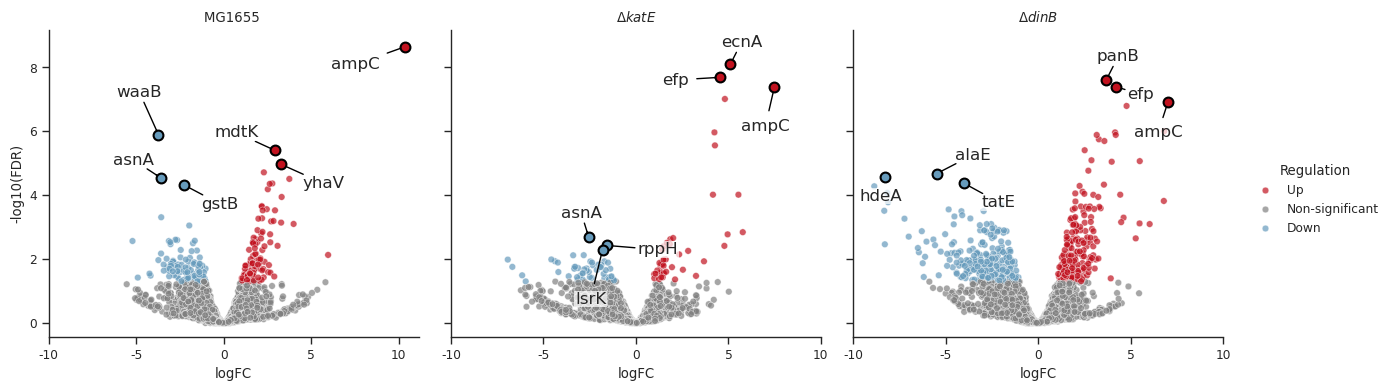

In [84]:
sns.set_context("paper")

# Prepare the data
df_plot = df_tr_2.copy()
df_plot["First"] = df_plot["First"].str.replace("_AMO_NT", " ").str.replace("katE", "$\Delta$$\it{katE}$").str.replace("dinB", "$\Delta$$\it{dinB}$")

# Set up the color palette
color_palette = {'Up': '#c1121f', 'Down': '#669bbc', 'Non-significant': 'grey'}

# Get unique values for First column
first_values = df_plot["First"].unique()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

# Ensure axes is always a list, even for a single subplot
if len(first_values) == 1:
    axes = [axes]

# Plot each subplot
for ax, first_value in zip(axes, first_values):
    data = df_plot[df_plot["First"] == first_value]
    
    # Plot all points with specified legend order
    sns.scatterplot(data=data, x="logFC", y="log10FDR", hue="label", 
                    palette=color_palette, alpha=0.7, ax=ax,
                    hue_order=['Up', 'Non-significant', 'Down'])
    
    texts = []  # To store Text objects for adjustText
    
    # Highlight top 5 up and down regulated genes based on log10FDR
    for regulation in ['Up', 'Down']:
        top_5 = data[data['label'] == regulation].nlargest(3, 'log10FDR')
        
        ax.scatter(top_5['logFC'], top_5['log10FDR'], 
                   color=color_palette[regulation], 
                   s=50, edgecolors='black', linewidths=1.5, zorder=5)
        
        for _, row in top_5.iterrows():
            text = ax.text(row['logFC'], row['log10FDR'], row['gene_name'], 
                           ha='center', va='center', fontsize=12,
                           bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))
            texts.append(text)
    
    # Adjust text positions
    adjust_text(texts, ax=ax,
                expand=(2.5, 2.5),  # expand text bounding boxes
                arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
    ax.set_xlabel("logFC")
    ax.set_ylabel("-log10(FDR)")
    ax.set_title(first_value)
    
    # Set specific x-axis ticks
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_xticklabels([-10, -5, 0, 5, 10])
    
    # Remove legend from all but the last subplot
    if ax != axes[-1]:
        ax.get_legend().remove()

# Adjust the legend for the last subplot
axes[-1].legend(title="Regulation", bbox_to_anchor=(1.05, 0.6), loc='upper left', frameon=False)

# Adjust the layout and display the plot
plt.tight_layout()
sns.despine()
plt.savefig('documentation/RNA/scientific_questions/plots/tr.png', dpi=300, bbox_inches='tight')
plt.show()


**Figure 4**